In [14]:
%%time
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.options.mode.chained_assignment = None 
pd.options.display.width = 0
import os
import datetime
from IPython.core.display import display, HTML
pd.set_option('display.max_colwidth', -1)
import configparser
display(HTML("<style>.container { width:100% !important; }</style>"))

/Users/jarryxiao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # This is added back by InteractiveShellApp.init_path()


CPU times: user 4.13 ms, sys: 22.7 ms, total: 26.8 ms
Wall time: 93.5 ms


In [15]:
%%time
cfg = configparser.ConfigParser()
cfg.read("/Users/jarryxiao/projects/pokernow_hud/config.ini")
log_dir = os.path.join("/Users/jarryxiao/projects/pokernow_hud/", cfg["PATHS"]["log_dir"])
img_dir = os.path.join("/Users/jarryxiao/projects/pokernow_hud/", cfg["PATHS"]["image_dir"])
graph_dir = os.path.join("/Users/jarryxiao/projects/pokernow_hud/", cfg["PATHS"]["pnl_graph_dir"])

REPLACE = list(cfg._sections["REPLACE"].items())
aliases = cfg._sections["ALIASES"]

game_logs = []
for fname in os.listdir(log_dir):
    path = os.path.join(log_dir, fname)
    t = datetime.datetime.fromtimestamp(os.path.getmtime(path))
    if t.year < 2021:
        continue
    df = pd.read_csv(path)
    df["session"] = fname.split(".")[0].strip("poker_now_log_")
    print(fname.split(".")[0].strip("poker_now_log_"))
    game_logs.append(df)
    
game = pd.concat(game_logs)
print(game.shape)
game = game.sort_values(["at", "order"]).reset_index(drop=True)
game["at"] = pd.to_datetime(game["at"])
game = game[~game.entry.str.contains("WARNING")]
game.entry = game.entry.str.replace('"', "")
for source, target in REPLACE:
    game.entry = game.entry.str.lower().str.replace(source, target)
game["hand_id"] = None
is_starting_hand = game.entry.str.startswith("-- starting")
starting_hands = game.loc[is_starting_hand, "entry"]
i = starting_hands.str.split(" ", expand=True)[3].str[1:].astype(int)
game.loc[is_starting_hand, "hand_id"] = i
game.hand_id = game.hand_id.ffill()
game["street"] = None
is_pre = game.entry.str.startswith("-- starting hand")
is_flop = game.entry.str.startswith("flop")
is_turn = game.entry.str.startswith("turn")
is_river = game.entry.str.startswith("river")
is_ending = game.entry.str.startswith("-- ending hand")
game.loc[is_pre, "street"] = "pre"
game.loc[is_flop, "street"] = "flop" 
game.loc[is_turn, "street"] = "turn" 
game.loc[is_river, "street"] = "river"
game.loc[is_ending, "street"] = "" 
game.street = game.street.ffill()
street_ids = {
    "pre": 0,
    "flop": 1,
    "turn": 2,
    "river": 3,
}
game["street_id"] = game.street.map(street_ids)


NUMBER_REGEX = r'(\s[0-9]+[\.]?[0-9]*(\s|$))'
has_player_info = game.entry.str.contains(" @ ")
player_subset = game.loc[has_player_info]
parsed_entry = player_subset.entry.str.split(" @ ", expand=True)
names = parsed_entry[0].str.split(expand=True).ffill(axis=1)
game.loc[has_player_info, "player"] = names[names.shape[1] - 1].str.lower()
game.loc[has_player_info, "player_id"] = parsed_entry[1].str.split(expand=True)[0]
result = game
result["folded"] = result.entry.str.endswith("folds")
result["showdown"] = result.entry.str.contains("collected") & result.entry.str.contains("with")
result["uncalled"] = result.entry.str.contains("uncalled")
result["betting"] = 0 
result["blinds"] = result.entry.str.contains(r"blind")
result["calls"] = result.entry.str.contains(r"calls")
result["raises"] = result.entry.str.contains("raises")
result["folds"] = result.entry.str.contains("folds")
is_bet = result.entry.str.contains(r"bets|posts|raises|calls")
is_payoff = result.entry.str.contains(r"collected")
result["all_in"] = result.entry.str.contains("all in")
result["bet"] = -result.entry.str.extract(NUMBER_REGEX)[0].str.strip().astype(float).round(2)
result.loc[result.folded, "bet"] = 0
result.loc[is_payoff, "bet"] *= -1
result.loc[result.uncalled, "bet"] *= -1
result.loc[is_payoff, "street"] = "result"
result.loc[result.uncalled, "street"] = "uncalled"
missed_sb = result.entry.str.contains("missing small blind")
missed_bb = result.entry.str.contains("missing big blind")
result.loc[missed_sb, "street"] = "missed_sb"
result.loc[missed_sb, "street"] = "missed_bb"
result.bet.update(result.loc[result.street == "result"].groupby(["session", "hand_id", "player"]).bet.cumsum())
result = result.merge(result.groupby(["session", "hand_id"]).showdown.any().reset_index(), on=["session", "hand_id"], suffixes=["_raw", ""])

aliases_map = dict(zip(result.player.dropna().str.lower().unique(), result.player.dropna().str.lower().unique()))
aliases_map.update(aliases)
print(aliases_map)


result["player"] = result["player"].map(aliases_map)

# result["amt"] =
print("pot calc")
result = result.join(
    result.query("bet < 0 and (raises or blinds or calls)")
    .groupby(["session", "hand_id", "street_id", "player"]).bet.diff().rename("amt")
    .dropna()
    .to_frame(),
    how="left"
)

pots = (
    result.query("bet < 0")
    .groupby(["session", "hand_id", "street_id", "player"]).bet.last()
    .groupby(["session", "hand_id"]).cumsum().bfill().ffill()
    .rename("pot")
    .reset_index()
)


result = result.merge(pots, how="left", on=["session", "hand_id", "street_id", "player"])
result.loc[result.duplicated(["session", "hand_id", "street_id", "player"], keep="last"), "pot"] = None 
result["pot"] *= -1



hands = result.query("bet == bet and bet != 0 and hand_id == hand_id and street != ''")
betting_action = hands.drop_duplicates(["player", "session", "hand_id", "street"], keep="last").round(2)
bugs = betting_action.groupby(["session", "hand_id"]).bet.sum().round(2).reset_index().query("bet != 0")
# If this DataFrame is empty, the accounting is probably correct
print("Accounting Errors:")
if bugs.shape[0] == 0:
    print("No obvious accounting bugs found")
    print()
else:
    display(bugs)
    print()

def debug(bug_index):
    try:
        b = bugs.loc[bug_index]
        s = b.session
        h = b.hand_id
        display(result.query("session == @s and hand_id == @h"))
        display(betting_action.query("session == @s and hand_id == @h"))
    except:
        pass



result["date"] = result["at"].dt.strftime("%Y-%m-%d")
remap = dict(result[["session", "date"]].drop_duplicates(["session"]).values)
result["date"] = result["session"].map(remap)

print("All sessions/dates recorded")
display(result[["date", "session"]].drop_duplicates())


sessions = result[["date", "session"]].drop_duplicates()
session_map = dict(zip(sessions.session, sessions.date))

I7hm0DpD2CrqB33aS9HOVkfS
q_qe8I1FRw-v_asK7RXl0AKD
uFa7GUVcbE8JxgnWSByPHlx7
bjDm07z_jU2MQFeg5h_Y3onm8
7g2w_vbpjVV1I6FCZ2TGGx_1m
IQIJsRcb9bUXQMW1xLxrS1x-
WKlU2LExdwzDW4AmswDOw_xE
HgWZjAySXw7UcsWWBpW-we_6
m16AO8faHybSUQZhFJzmtAEu7
WF6KvodILiIVJ6BPOTGV5HNj5
Zg1dkCpF0jDNXsw8RMBtP4CK
m9-PPl6vgWMW9UEVvgGKJBNbG
5DINHhQVL6oTcNPlxho0keyVC
LlTA_d4WFTn-fmapxHyyeGHNm
YX5eSawzWYstuac0fSjMOJYdD
Sa7UHDOgdhNbbZ35OEG1PPTla
M4ARsEKeh7dFz-Ns4jokpkn7F
5WYPeM5uEEab543ctdgXvWzc
-E8ALnLAQqi78M-ksysTWGnH7
Q3_FZkxEGsdTOgaShTslOhlf8
BodwneovrpKxfjeyFU1i55L
jIHWUxTlGVD6Q7zDRCwp1tVIB
b0U-CTlnlVy3PzJd6we2R-yE3
HC_9HnLC2SEQQLlgNSRorfYR
QcU2fP0u4St8bafC6YSZNxmD1
LfF3ZGdolCFHBirCSoE97OvnN
Q-tCIg7TCcWpfGhKnQv3HSu
mTDFktABnxpaD6rg7HgXpzw7
R-4j0aoZn4a03va8kyGttVDX
zD70CZ-veA_jC6hZCFMkqifWG
jLTF2NnPuPvKzGse0k97jgxYZ
jLAcfZrgktAVC1M-srx3Fc7Bh
ubxTywLx4l1nwfHhntx1mPt31
7wTve4gW4yQLvOuHczhcaC3R
Ngg-w4GUkHlSQDC_KJXv6CFg7
QxKU0Ups3bezpPfaPw8OW2ehO
WD49A6ceNcF3NW_LuzgGd81X
8NdToSjJrG9C50oxbz7G6bDv-
jA7xiPsVvvzVL5ZMpReGyVCCY
hBP

session  hand_id  bet
10669  RMbqgUvGb9P7dZr6j0PbPvjYD  118.0    0.5


All sessions/dates recorded


date                    session
0       2021-01-19  9vnH8x5uZk0B8qi3Rph0z3mT 
3262    2021-01-19  HC_9HnLC2SEQQLlgNSRorfYR 
10088   2021-01-22  b0U-CTlnlVy3PzJd6we2R-yE3
18906   2021-01-25  2kN33xbxgavjQalTzbkVwY53Z
26833   2021-01-26  7wTve4gW4yQLvOuHczhcaC3R 
34594   2021-01-27  OeYW2DkhKCS3A48mVKMfM6rhR
42545   2021-01-28  bjDm07z_jU2MQFeg5h_Y3onm8
50894   2021-01-29  R-4j0aoZn4a03va8kyGttVDX 
55541   2021-01-30  947eqsUmJDR1n9MjNsFzm9ntI
60394   2021-01-31  NZIwlI8eiGaLhpUeLHlayfd  
70881   2021-02-02  fUgYjfOwDrQ3iziVMCMeehWD 
76970   2021-02-02  ueg9QQUxaX11AhzAor8-XsoLW
81116   2021-02-03  vdSJk_0H42ox_Ry1KMXfcvvKb
88717   2021-02-04  I7hm0DpD2CrqB33aS9HOVkfS 
97047   2021-02-04  FGvC60jqNFt5rNTcrZ0JA_hz 
99448   2021-02-06  fRjBfxrmWjlgWdU5yAztt2CIc
114742  2021-02-07  txls5VgqF3KYdjYW-aXs8Ynb5
118956  2021-02-08  f7DKOYRx_cSZlw4H8c3aPl4cy
122354  2021-02-09  dcYmCyqqwtKA4YAeQtXEtvIHK
136223  2021-02-10  BodwneovrpKxfjeyFU1i55L  
139168  2021-02-11  mUkVB8TeMh4ovy_kpQnWlKKFf
141292  2021-02-12  ubxTywLx4l1nwfHhntx1mPt31
144078  2021-02-13  Vv6Z8y8Rpkjm_5Qi7jVrG1DqA
144084  2021-02-14  mmddvoRSQuxAIpQL-oJ4AR9PF
149059  2021-02-17  Sa7UHDOgdhNbbZ35OEG1PPTla
156172  2021-02-17  xJsqHAwTNGMfQiAbumDJzoKWW
157577  2021-02-18  Zg1dkCpF0jDNXsw8RMBtP4CK 
160733  2021-02-19  HgWZjAySXw7UcsWWBpW-we_6 
164869  2021-02-20  -E8ALnLAQqi78M-ksysTWGnH7
165667  2021-02-21  Ngg-w4GUkHlSQDC_KJXv6CFg7
167728  2021-02-21  jLTF2NnPuPvKzGse0k97jgxYZ
171892  2021-02-23  IQIJsRcb9bUXQMW1xLxrS1x- 
176510  2021-02-24  viKL1A4DlZ_4XyMYhC4fPLQCz
182998  2021-02-25  sFCNqGIHQ4H8972gVVwtSVSz 
186131  2021-02-26  8qr0PwgUgrqp_IaA3oIxY644y
191629  2021-02-27  QcU2fP0u4St8bafC6YSZNxmD1
193595  2021-02-28  5DINHhQVL6oTcNPlxho0keyVC
199448  2021-03-02  YX5eSawzWYstuac0fSjMOJYdD
204049  2021-03-02  LfF3ZGdolCFHBirCSoE97OvnN
205452  2021-03-03  ha9kxbXIPwnNTGeGhhzSVSmY0
209945  2021-03-04  tcDl0nhmrvoNAORk5S9T-8Uss
214968  2021-03-05  bk3eVptlZE_fWzeQ4t8U2T5e4
218464  2021-03-06  RMbqgUvGb9P7dZr6j0PbPvjYD
222960  2021-03-08  aGVkajr_dWs66OdWDx5FKz-tB
226722  2021-03-09  8NdToSjJrG9C50oxbz7G6bDv-
227308  2021-03-10  4tWuseUgnwcY0hqfWEgcVE_cB
230374  2021-03-15  RvH3yuG6E06AIjl7vbBN7juTF
231800  2021-03-16  jAG1v5Ql4JNihy6071HH8db19
232547  2021-03-18  x79AjEidHdym-GFl_PKXivmDB
237320  2021-03-18  hBPXWNDHh6l_fiib3G7HWHGv 
238539  2021-03-18  BcpElBF1lyGC7EZ6P2acEMxN 
241071  2021-03-19  BMW-m98IkF24DMsUOIWVS9vwx
244018  2021-03-20  QxKU0Ups3bezpPfaPw8OW2ehO
245832  2021-03-20  zY8tfir7OhKjbAaNhva2EVkjC
245859  2021-03-21  mvXDlh7lIKTnmeo4vL9AHK61V
256942  2021-03-24  WF6KvodILiIVJ6BPOTGV5HNj5
260089  2021-03-25  NBnwHHeqhQuJUmH7OfTgoEA7R
261863  2021-03-26  zD70CZ-veA_jC6hZCFMkqifWG
265503  2021-03-27  1zSwClSW9pkbztszftJhBCWZI
270534  2021-03-29  uy6Kils5vtfl1S2luYdtt02fP
274127  2021-03-30  3yDOPHxVBaVj5A1S098ilM   
276835  2021-03-30  5WYPeM5uEEab543ctdgXvWzc 
279919  2021-03-31  zajmup736lmLo7Pe7vgyQdxlq
284899  2021-03-31  2ZCBs-mPh4yvyHXUlg0XNDQRE
289420  2021-04-01  KsO8nReyb2GYV2KfuAjr-Fpeh
291881  2021-04-01  jLAcfZrgktAVC1M-srx3Fc7Bh
296012  2021-04-04  mErxYWL1o898IK1O3h1QQB7v1
300546  2021-04-06  0V1_heUFMhwzAGENb5SpZF8_S
301181  2021-04-06  WKlU2LExdwzDW4AmswDOw_xE 
305037  2021-04-07  q_qe8I1FRw-v_asK7RXl0AKD 
311343  2021-04-08  WD49A6ceNcF3NW_LuzgGd81X 
314035  2021-04-08  MShTidnaZT4zdLesZWEU24I  
320658  2021-04-09  jA7xiPsVvvzVL5ZMpReGyVCCY
327789  2021-04-11  -y5oHCW33lqC7UpFuxLckE-qa
329285  2021-04-12  LlTA_d4WFTn-fmapxHyyeGHNm
333272  2021-04-15  dIbVqe9X-j0kfSIRiW9QInctO
337753  2021-04-17  Ek7PIR4JHr8IlxmA3kANuLLpi
343168  2021-04-18  Q3_FZkxEGsdTOgaShTslOhlf8
345193  2021-04-18  ivs4cWL_sR6_W0oThYTCvbl6 
347838  2021-04-22  7g2w_vbpjVV1I6FCZ2TGGx_1m
349456  2021-04-22  m16AO8faHybSUQZhFJzmtAEu7
352868  2021-04-24  bJrjHAChZWuIpq-TpPQuRu8B 
354057  2021-04-24  M4ARsEKeh7dFz-Ns4jokpkn7F
356187  2021-04-24  QkOrncw_97H1TFzyKi13iJGsx
359230  2021-04-24  XKMKiOKV-xnnKSDnecU2_Rgq 
365341  2021-04-27  mTDFktABnxpaD6rg7HgXpzw7 
368374  2021

CPU times: user 29.9 s, sys: 4.65 s, total: 34.5 s
Wall time: 48.8 s


In [5]:
result.query("player == 't'").head()

entry  \
356994  the player andrew t @ zp5ldr9ldp requested a seat.            
357169  the player andrew t @ zp5ldr9ldp canceled the seat request.   

                                     at            order  \
356994 2021-04-24 09:18:43.426000+00:00  161925592342700   
357169 2021-04-24 09:26:02.545000+00:00  161925636254700   

                          session  hand_id street  street_id player  \
356994  QkOrncw_97H1TFzyKi13iJGsx  44.0     pre    0.0        t       
357169  QkOrncw_97H1TFzyKi13iJGsx  53.0     river  3.0        t       

         player_id  folded  showdown_raw  uncalled  betting  blinds  calls  \
356994  zp5ldr9ldp  False   False         False     0        False   False   
357169  zp5ldr9ldp  False   False         False     0        False   False   

        raises  folds  all_in  bet  showdown  amt  pot        date  
356994  False   False  False  NaN   False    NaN  NaN   2021-04-24  
357169  False   False  False  NaN   False    NaN  NaN   2021-04-24

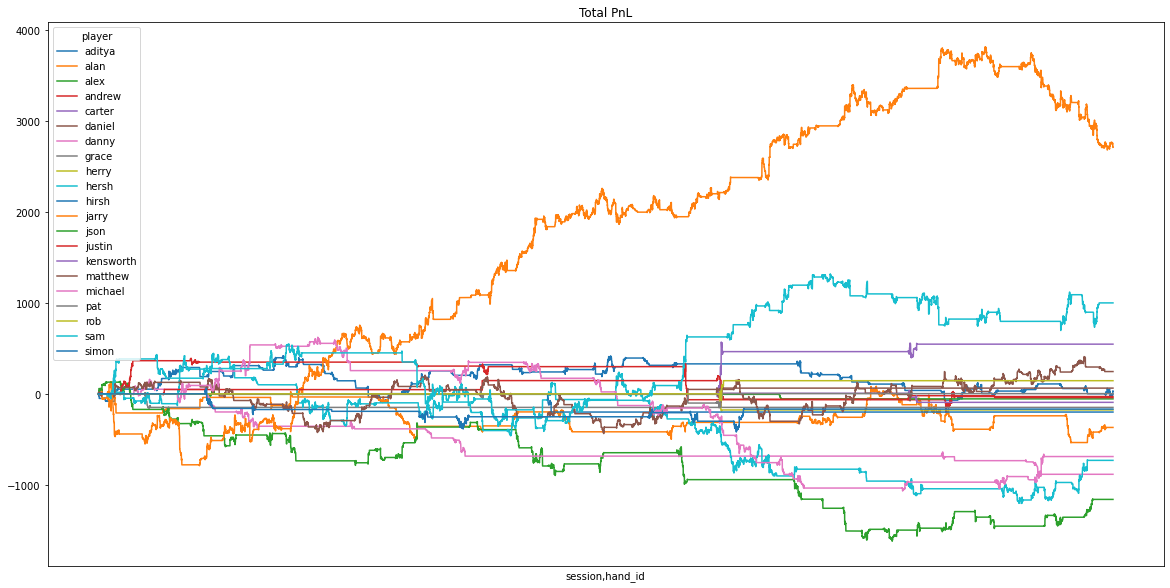

Profit by session (note dates are based on UTC)


player       aditya     alan        alex  andrew  carter  daniel   danny  \
session                                                                    
2021-01-19 -50.000   0.000    0.000000    0.00    0.00    0.00   -48.40    
2021-01-22  95.760   0.000    0.000000    0.00    0.00    0.00    0.00     
2021-01-25  0.000    0.000    0.000000    0.00    0.00    0.00    50.87    
2021-01-26  56.440   0.000    0.000000    0.00    0.00    0.00   -250.00   
2021-01-27 -50.000   0.000    0.000000    0.00    0.00    0.00   -200.00   
2021-01-28 -30.000   0.000    0.000000    0.00    0.00    0.00    0.00     
2021-01-29  0.000    0.000    0.000000    0.00    0.00    0.00    0.00     
2021-01-30  0.000    0.000    0.000000    0.00    0.00    0.00   -108.50   
2021-01-31  143.800  0.000    0.000000    0.00    0.00    0.00   -100.00   
2021-02-02  0.000    0.000    0.000000    0.00    0.00    0.00    0.00     
2021-02-03  61.540   0.000    0.000000    0.00    0.00    0.00   -150.00   
2021-02-04 -1.880    0.000    0.000000    0.00    0.00    0.00   -28.86    
2021-02-06  0.000    0.000    0.000000    0.00    0.00    0.00    0.00     
2021-02-07 -50.000   0.000    0.000000    0.00    0.00    0.00    0.00     
2021-02-08  0.000    0.000    0.000000    0.00    0.00    0.00    0.00     
2021-02-09  0.000    0.000    0.000000    0.00    464.89  63.29   0.00     
2021-02-10  136.600  0.000    0.000000    0.00    0.00    0.00    0.00     
2021-02-11 -70.000   0.000    0.000000    0.00    0.00    0.00    0.00     
2021-02-12  35.980   0.000    0.000000    0.00    0.00    0.00    0.00     
2021-02-13  0.000    0.000    0.000000    0.00    0.00    0.00    0.00     
2021-02-14  0.000    0.000    0.000000    0.00    82.13   0.00    0.00     
2021-02-17  7.050    0.000   -200.000000  0.00    0.00    0.00    0.00     
2021-02-18  15.360   0.000    59.070000   0.00    0.00    0.00    0.00     
2021-02-19 -100.000  0.000    0.000000    0.00    0.00    0.00    0.00     
2021-02-20 -50.000   0.000    59.670000   0.00    0.00    0.00    0.00     
2021-02-21 -50.000   0.000    0.000000    0.00    0.00    0.00    0.00     
2021-02-23 -80.000   0.000   -21.350000   0.00    0.00    0.00    0.00     
2021-02-24  0.000    0.000    27.750000   0.00    0.00    0.00    0.00     
2021-02-25  74.420   0.000    0.000000    0.00    0.00    0.00    0.00     
2021-02-26  114.680  0.000    8.570000    0.00    0.00    0.00    0.00     
2021-02-27  127.030  0.000   -78.660000   0.00    0.00    0.00    0.00     
2021-02-28  76.370   0.000   -50.000000   0.00    0.00    0.00    0.00     
2021-03-02 -50.000   0.000    35.645000   0.00    0.00    0.00    0.00     
2021-03-03 -100.000  67.790  -140.620000  0.00    0.00    0.00    0.00     
2021-03-04  49.540   0.000   -61.280000   0.00    0.00    0.00    0.00     
2021-03-05  15.870   61.100   0.000000    0.00    0.00    0.00    0.00     
2021-03-06 -50.000   153.680 -200.000000  0.00    0.00    0.00    0.00     
2021-03-08  65.450   0.000    0.000000    0.00    0.00    0.00    0.00     
2021-03-09 -50.000   0.000    0.000000    0.00    0.00    0.00    0.00     
2021-03-10  44.510   0.000   -48.650000   0.00    0.00    0.00    0.00     
2021-03-15 -35.680   0.000    0.000000    0.00    0.00    0.00    0.00     
2021-03-16 -50.000   0.000    0.000000    0.00    0.00    0.00    0.00     
2021-03-18 -50.000  -192.130  4.053333    0.00    0.00    0.00    0.00     
2021-03-19 -50.000   0.000    0.000000    0.00    0.00    0.00    0.00     
2021-03-20  0.000   -5.200    102.820000  0.00    0.00    0.00    0.00     
2021-03-21  0.000   -180.000  21.190000   0.00    0.00    0.00    0.00     
2021-03-24  0.000    18.560   32.690000   0.00    0.00    0.00    0.00     
2021-03-25  0.000    130.180  172.990000 -43.64   0.00    0.00    0.00     
2021-03-26 -57.230   119.620  93.240000   0.00    0.00    0.00    0.00     
2021-03-27  133.860 -210.000  0.000000    0.00    0.00    0.00    0.00     
2021-03-29  16.550   0.000    0.000000    0.00  


Cumulative Profit by session


player       aditya     alan         alex  andrew  carter  daniel   danny  \
session                                                                     
2021-01-19 -50.000   0.000    0.000000     0.00    0.00    0.00   -48.40    
2021-01-22  45.760   0.000    0.000000     0.00    0.00    0.00   -48.40    
2021-01-25  45.760   0.000    0.000000     0.00    0.00    0.00    2.47     
2021-01-26  102.200  0.000    0.000000     0.00    0.00    0.00   -247.53   
2021-01-27  52.200   0.000    0.000000     0.00    0.00    0.00   -447.53   
2021-01-28  22.200   0.000    0.000000     0.00    0.00    0.00   -447.53   
2021-01-29  22.200   0.000    0.000000     0.00    0.00    0.00   -447.53   
2021-01-30  22.200   0.000    0.000000     0.00    0.00    0.00   -556.03   
2021-01-31  166.000  0.000    0.000000     0.00    0.00    0.00   -656.03   
2021-02-02  166.000  0.000    0.000000     0.00    0.00    0.00   -656.03   
2021-02-03  227.540  0.000    0.000000     0.00    0.00    0.00   -806.03   
2021-02-04  225.660  0.000    0.000000     0.00    0.00    0.00   -834.89   
2021-02-06  225.660  0.000    0.000000     0.00    0.00    0.00   -834.89   
2021-02-07  175.660  0.000    0.000000     0.00    0.00    0.00   -834.89   
2021-02-08  175.660  0.000    0.000000     0.00    0.00    0.00   -834.89   
2021-02-09  175.660  0.000    0.000000     0.00    464.89  63.29  -834.89   
2021-02-10  312.260  0.000    0.000000     0.00    464.89  63.29  -834.89   
2021-02-11  242.260  0.000    0.000000     0.00    464.89  63.29  -834.89   
2021-02-12  278.240  0.000    0.000000     0.00    464.89  63.29  -834.89   
2021-02-13  278.240  0.000    0.000000     0.00    464.89  63.29  -834.89   
2021-02-14  278.240  0.000    0.000000     0.00    547.02  63.29  -834.89   
2021-02-17  285.290  0.000   -200.000000   0.00    547.02  63.29  -834.89   
2021-02-18  300.650  0.000   -140.930000   0.00    547.02  63.29  -834.89   
2021-02-19  200.650  0.000   -140.930000   0.00    547.02  63.29  -834.89   
2021-02-20  150.650  0.000   -81.260000    0.00    547.02  63.29  -834.89   
2021-02-21  100.650  0.000   -81.260000    0.00    547.02  63.29  -834.89   
2021-02-23  20.650   0.000   -102.610000   0.00    547.02  63.29  -834.89   
2021-02-24  20.650   0.000   -74.860000    0.00    547.02  63.29  -834.89   
2021-02-25  95.070   0.000   -74.860000    0.00    547.02  63.29  -834.89   
2021-02-26  209.750  0.000   -66.290000    0.00    547.02  63.29  -834.89   
2021-02-27  336.780  0.000   -144.950000   0.00    547.02  63.29  -834.89   
2021-02-28  413.150  0.000   -194.950000   0.00    547.02  63.29  -834.89   
2021-03-02  363.150  0.000   -159.305000   0.00    547.02  63.29  -834.89   
2021-03-03  263.150  67.790  -299.925000   0.00    547.02  63.29  -834.89   
2021-03-04  312.690  67.790  -361.205000   0.00    547.02  63.29  -834.89   
2021-03-05  328.560  128.890 -361.205000   0.00    547.02  63.29  -834.89   
2021-03-06  278.560  282.570 -561.205000   0.00    547.02  63.29  -834.89   
2021-03-08  344.010  282.570 -561.205000   0.00    547.02  63.29  -834.89   
2021-03-09  294.010  282.570 -561.205000   0.00    547.02  63.29  -834.89   
2021-03-10  338.520  282.570 -609.855000   0.00    547.02  63.29  -834.89   
2021-03-15  302.840  282.570 -609.855000   0.00    547.02  63.29  -834.89   
2021-03-16  252.840  282.570 -609.855000   0.00    547.02  63.29  -834.89   
2021-03-18  202.840  90.440  -605.801667   0.00    547.02  63.29  -834.89   
2021-03-19  152.840  90.440  -605.801667   0.00    547.02  63.29  -834.89   
2021-03-20  152.840  85.240  -502.981667   0.00    547.02  63.29  -834.89   
2021-03-21  152.840 -94.760  -481.791667   0.00    547.02  63.29  -834.89   
2021-03-24  152.840 -76.200  -449.101667   0.00    547.02  63.29  -834.89   
2021-03-25  152.840  53.980  -276.111667  -43.64   547.02  63.29  -834.89   
2021-03-26  95.610   173.600 -182.871667  -43.64   547.02  63.29  -834.89   
2021-03-27  229.470 -36.400  -182.871667  -43.64   547.02  63.29  -834.89

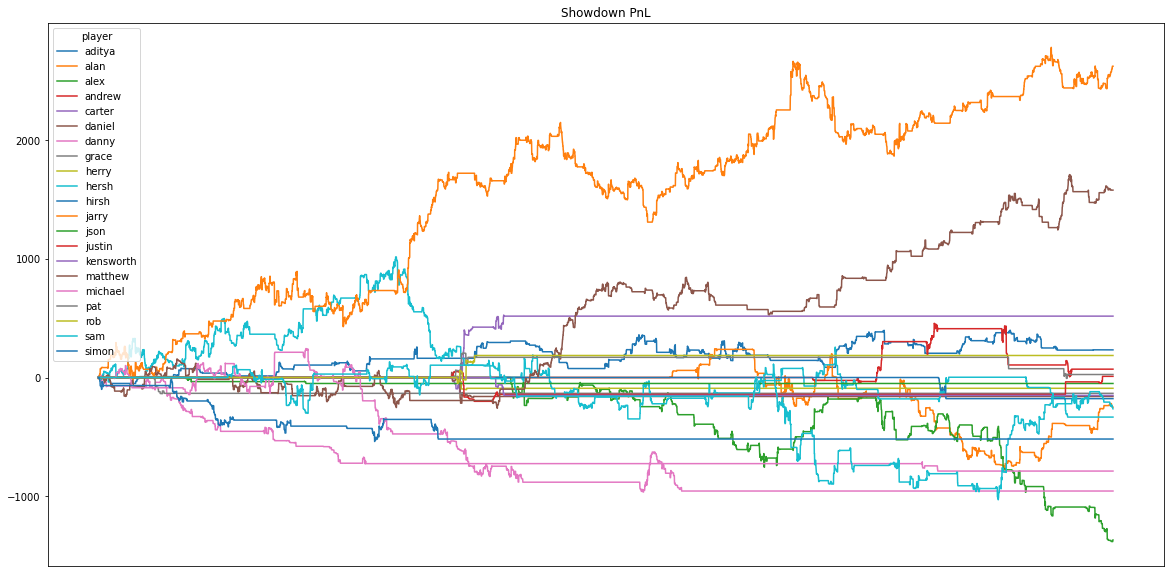

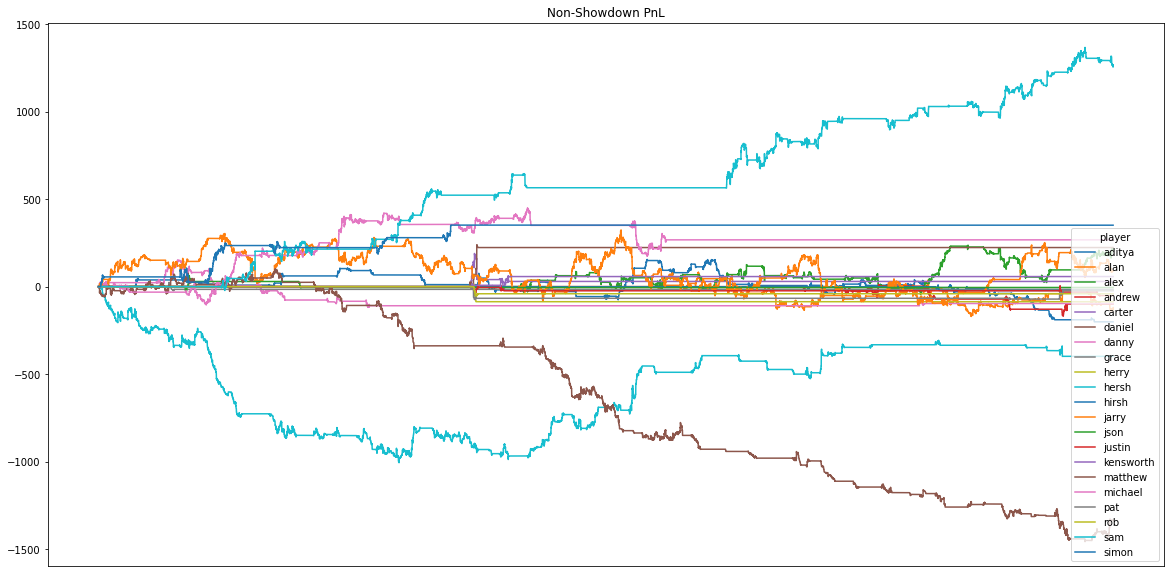

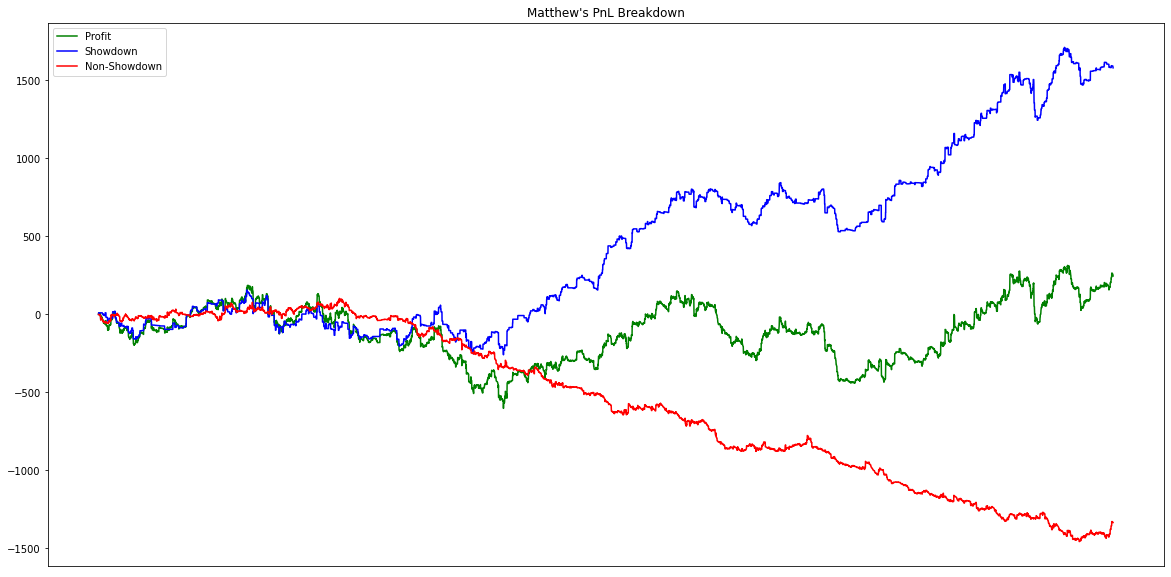

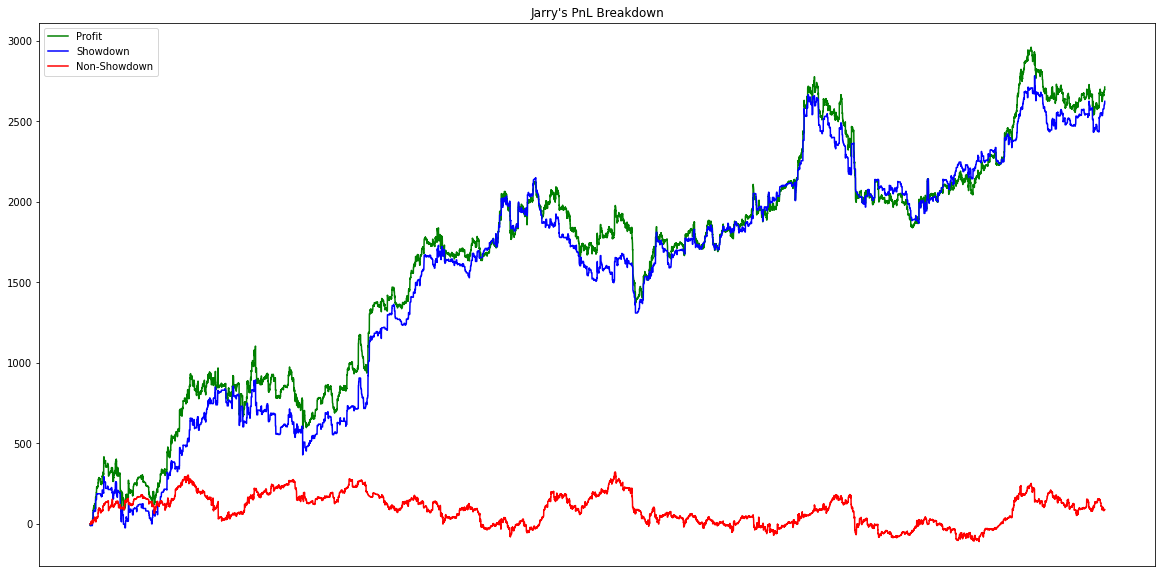

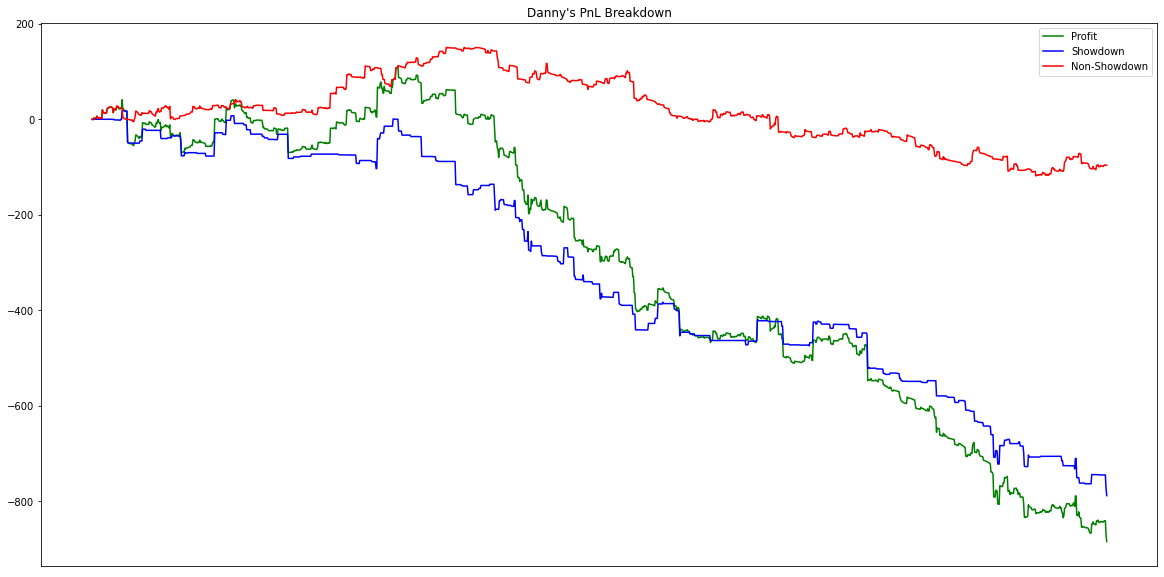

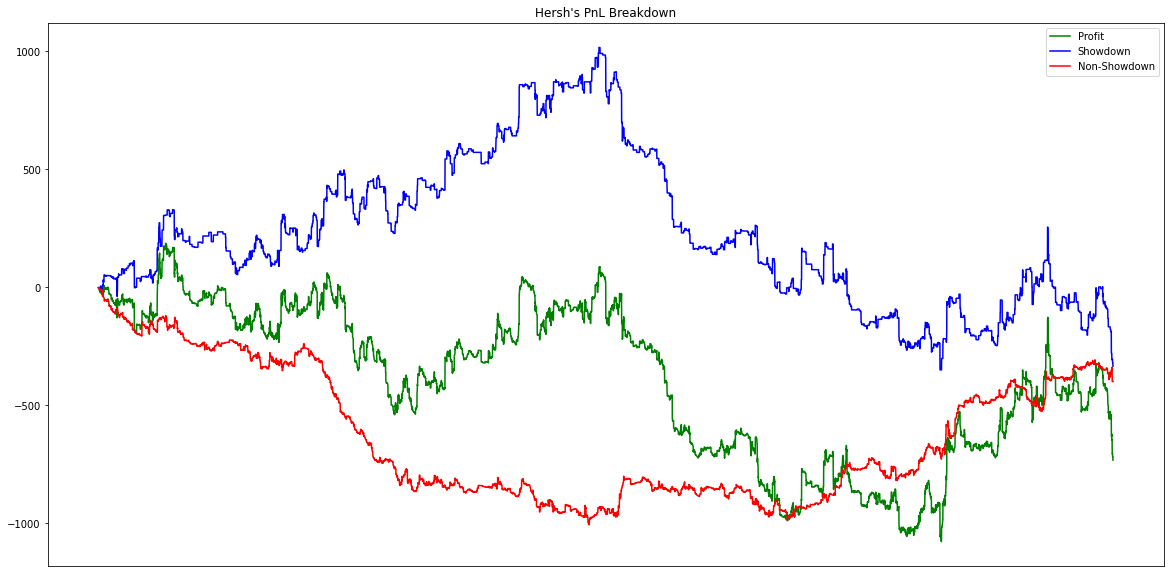

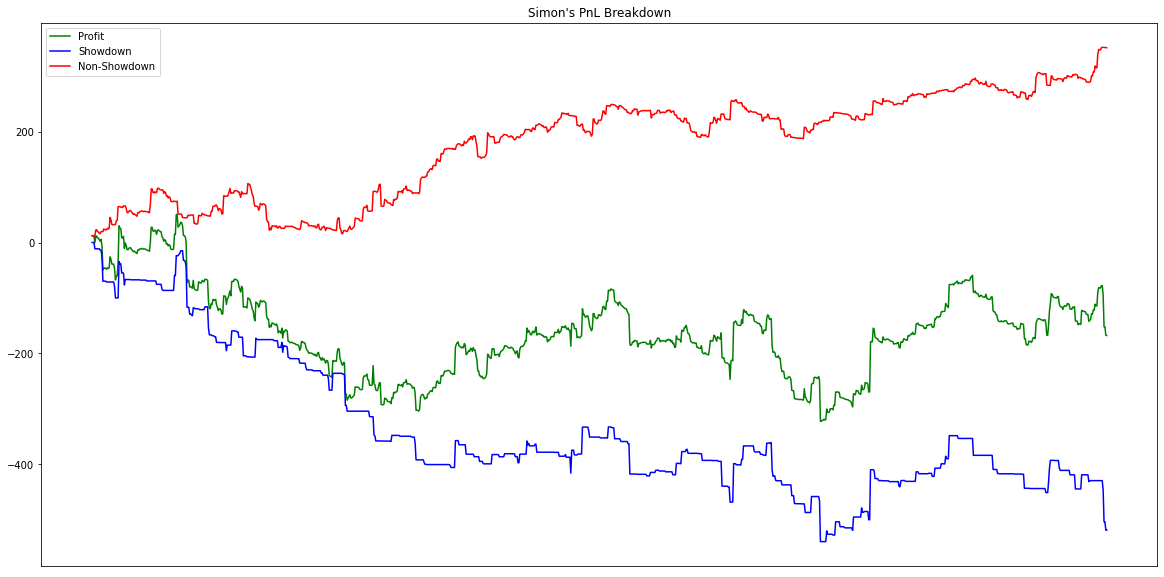

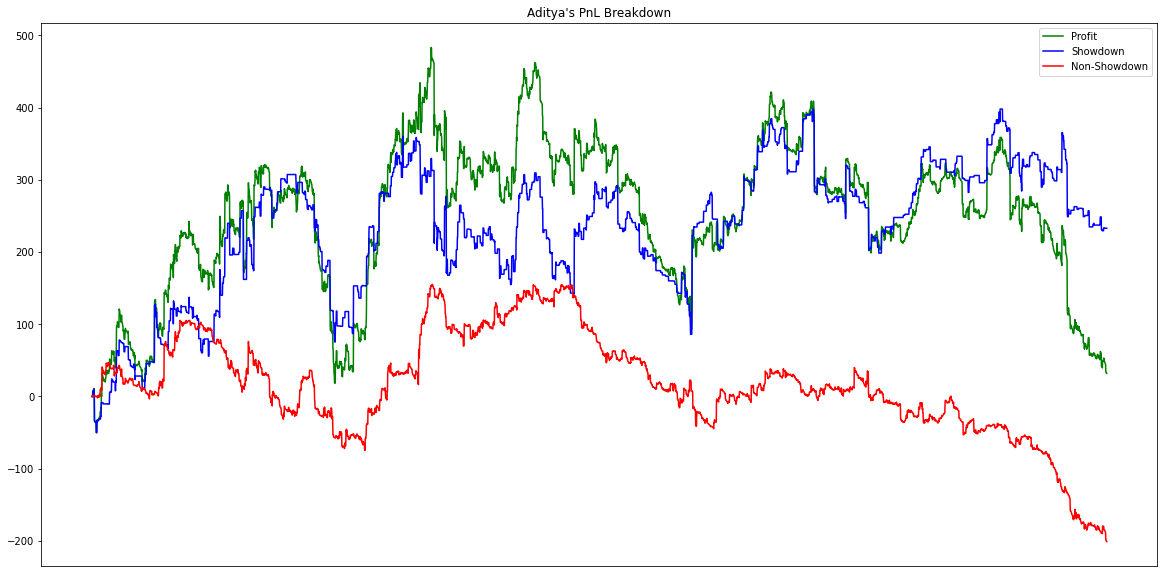

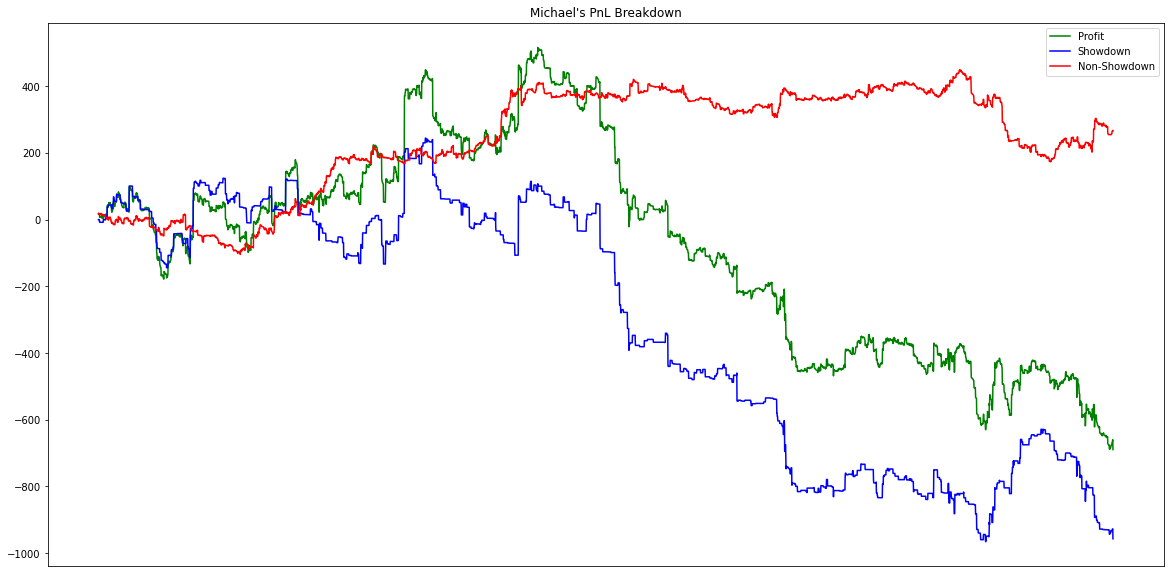

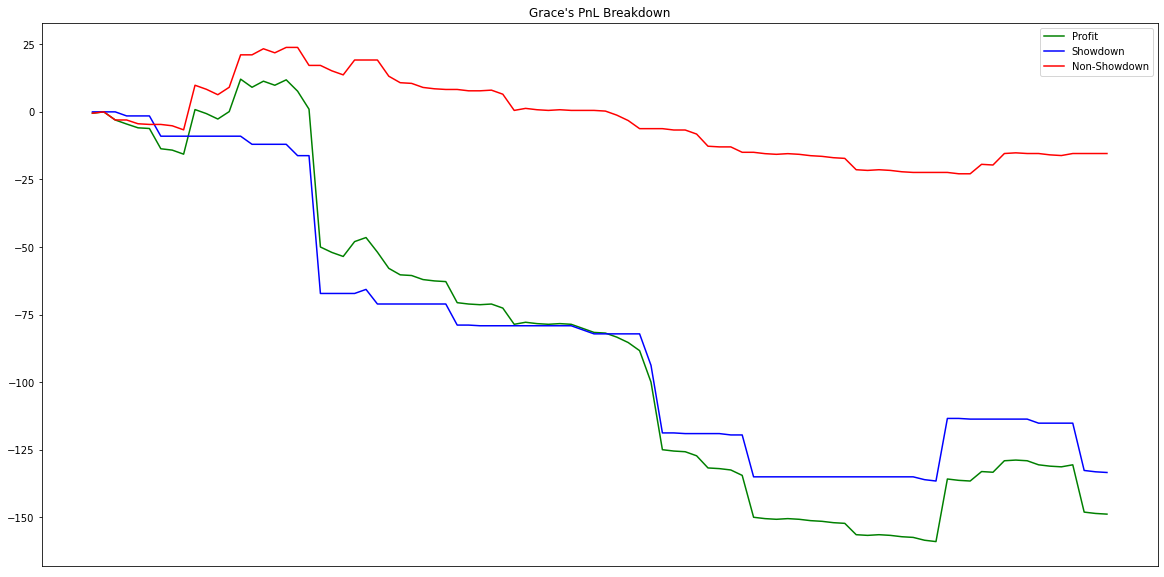

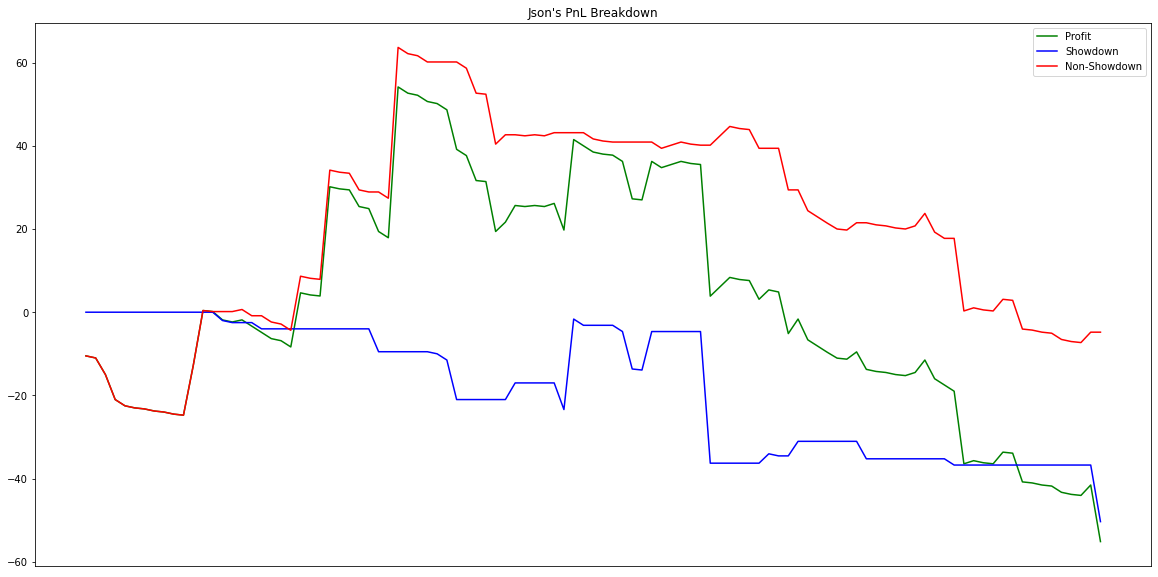

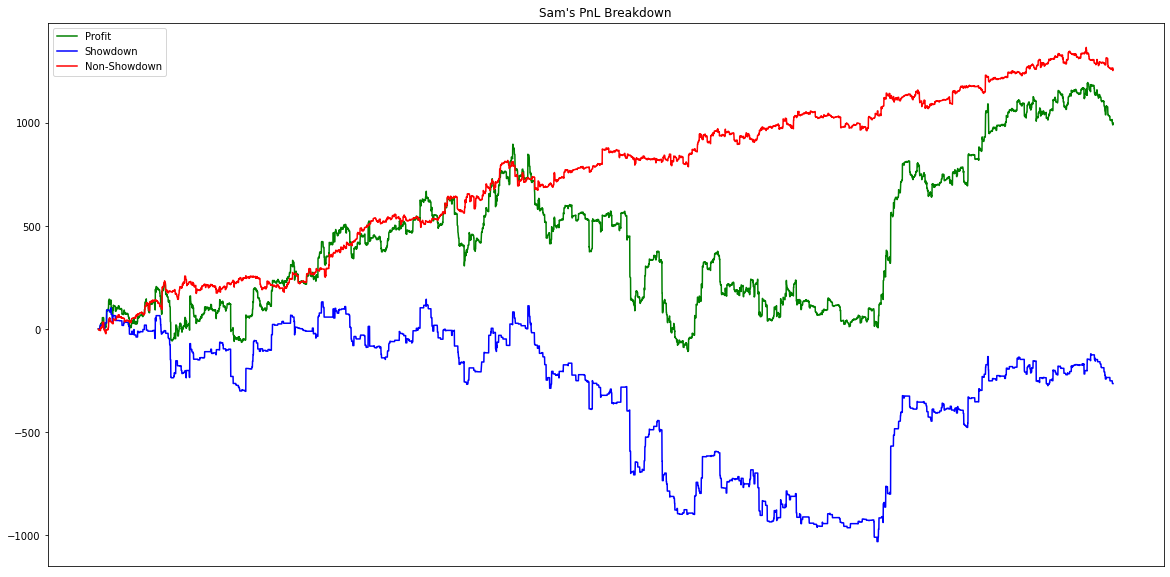

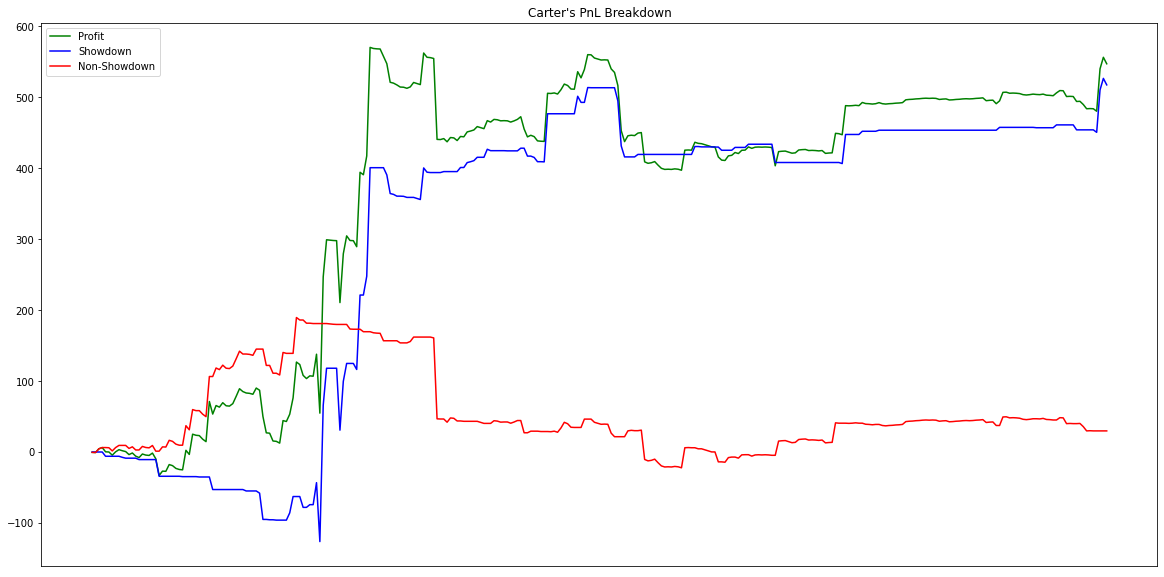

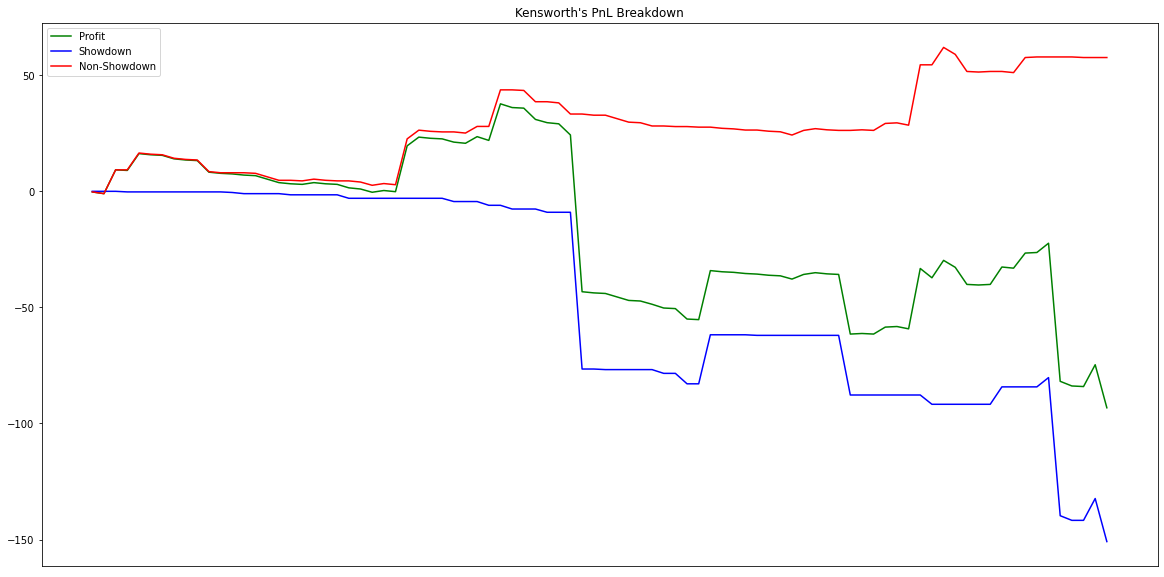

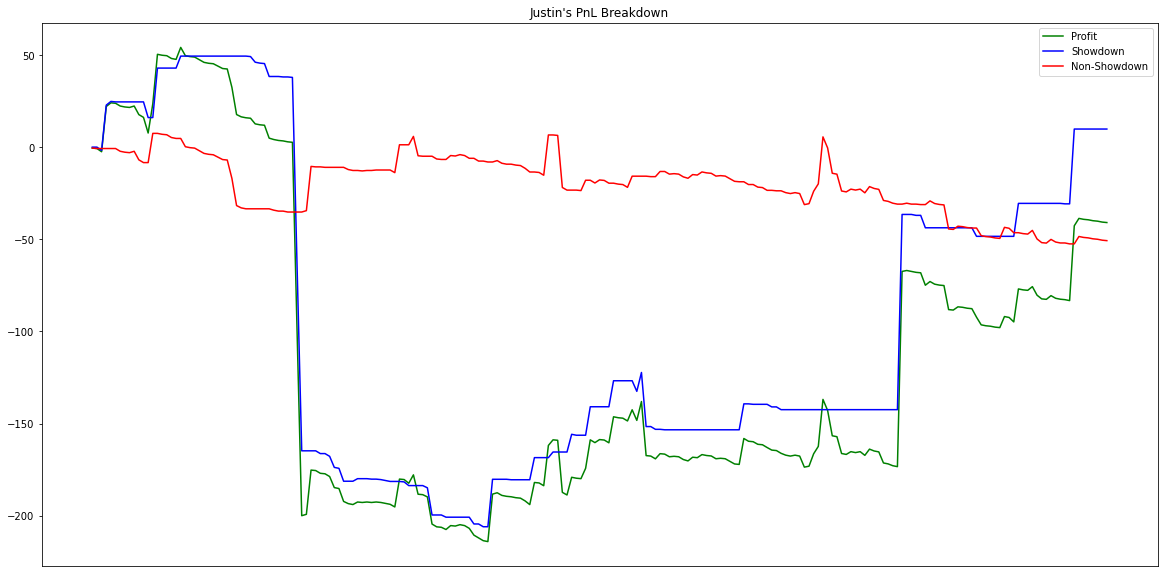

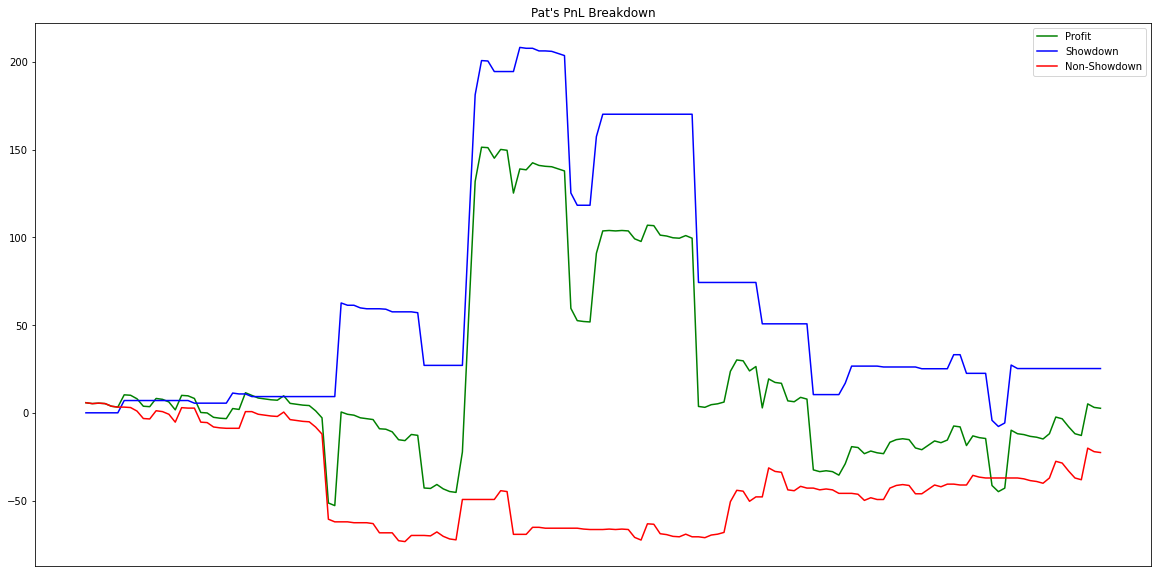

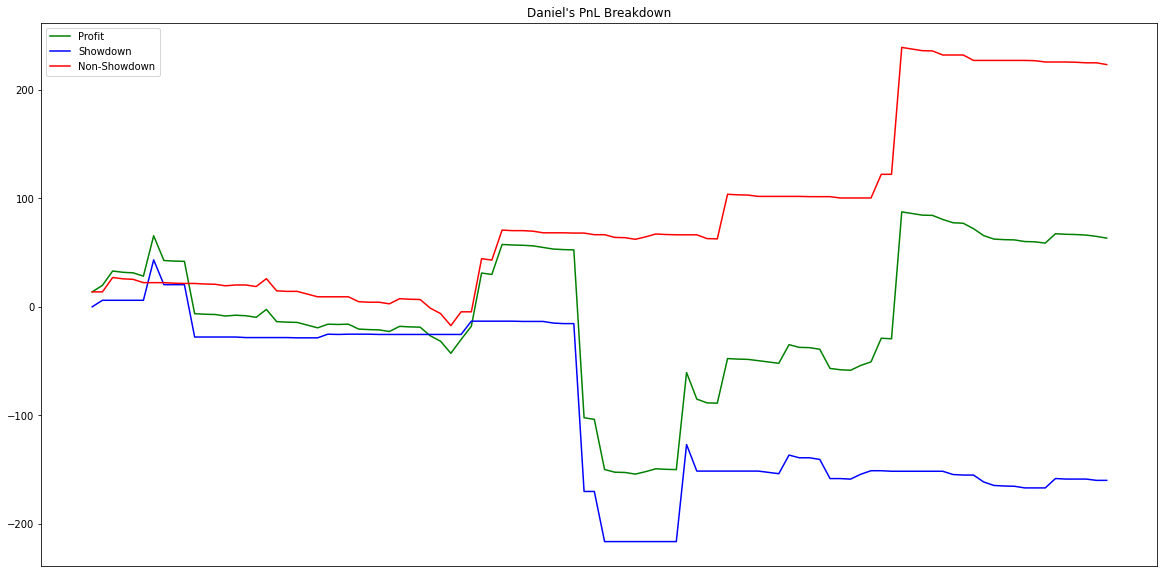

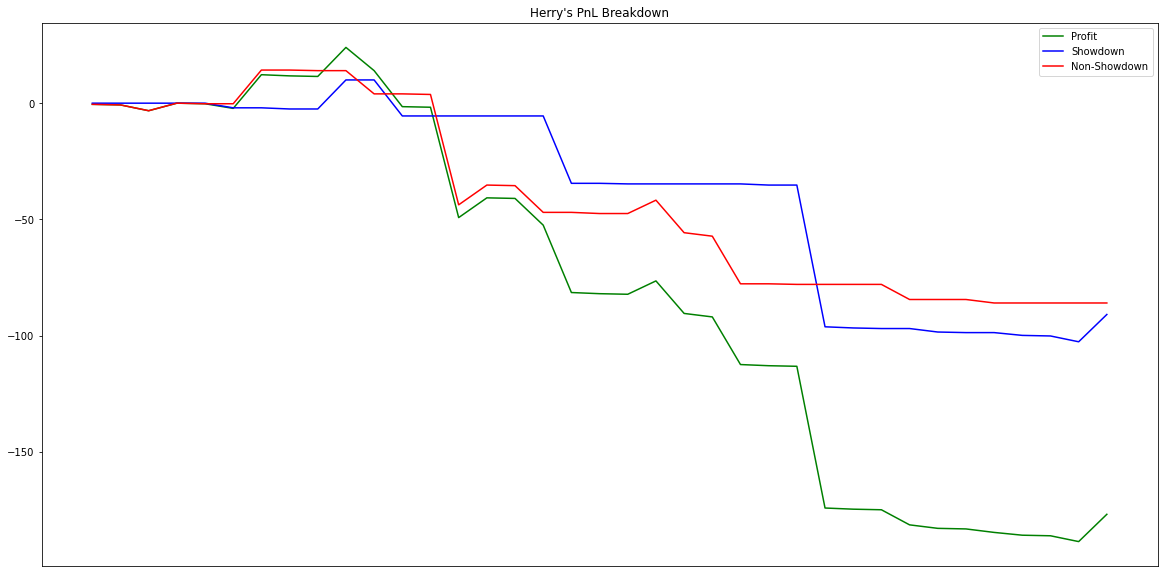

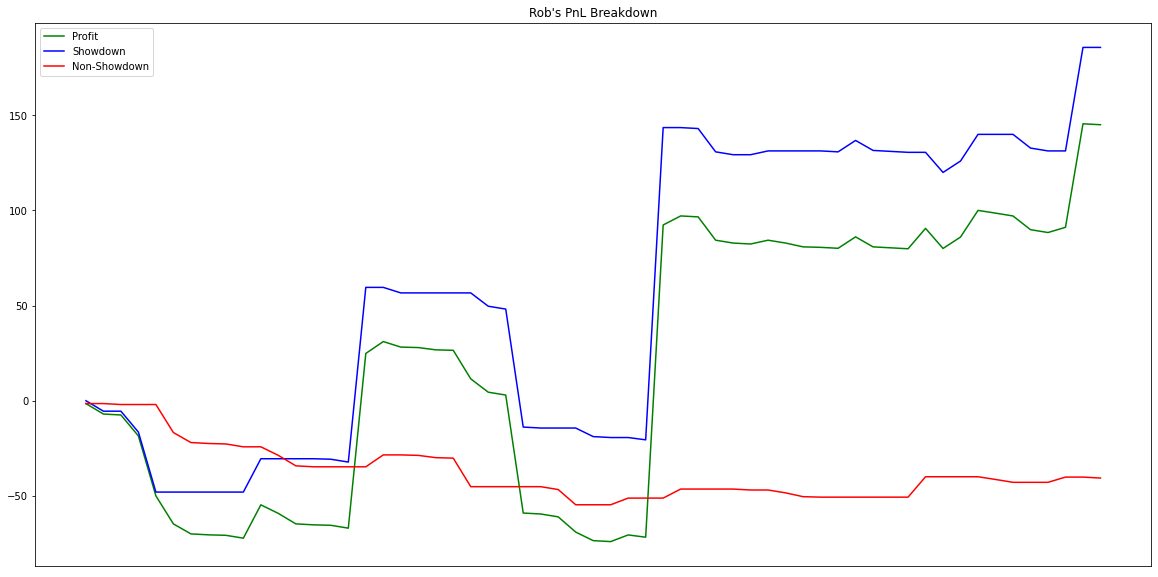

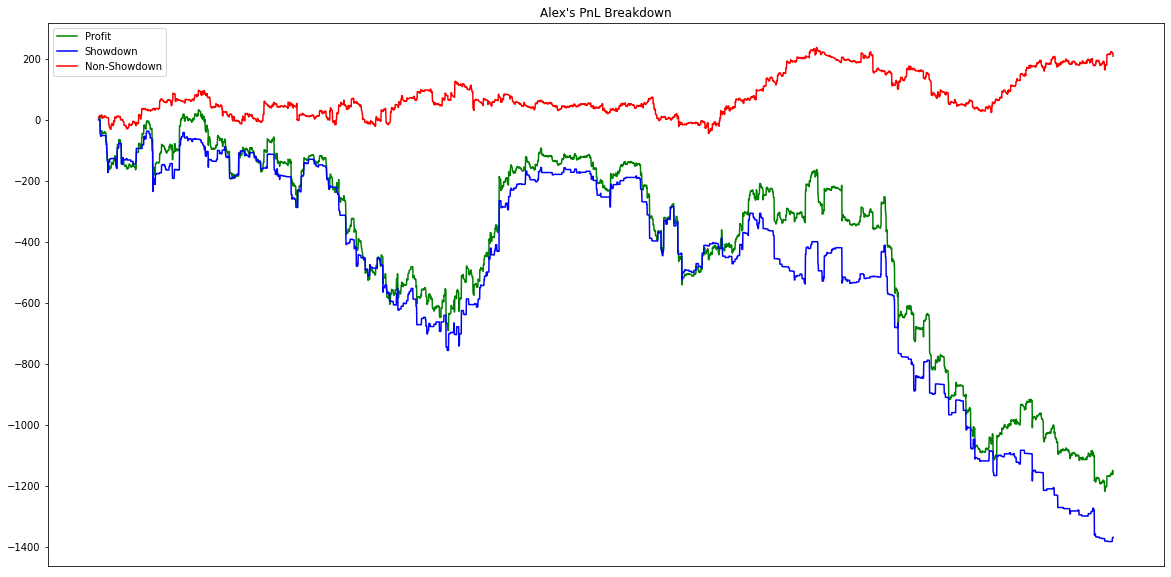

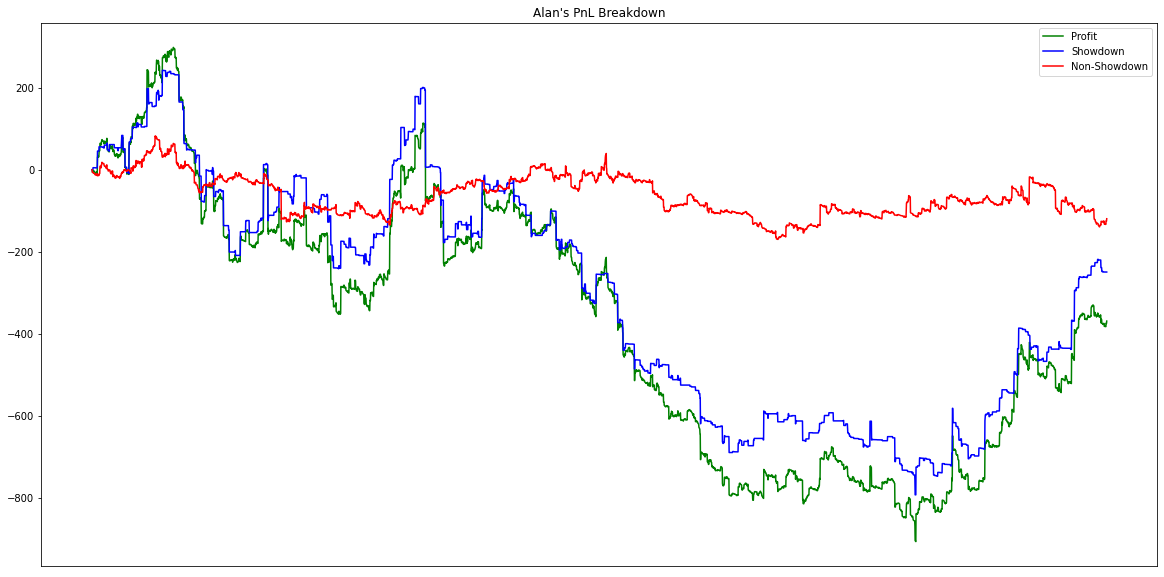

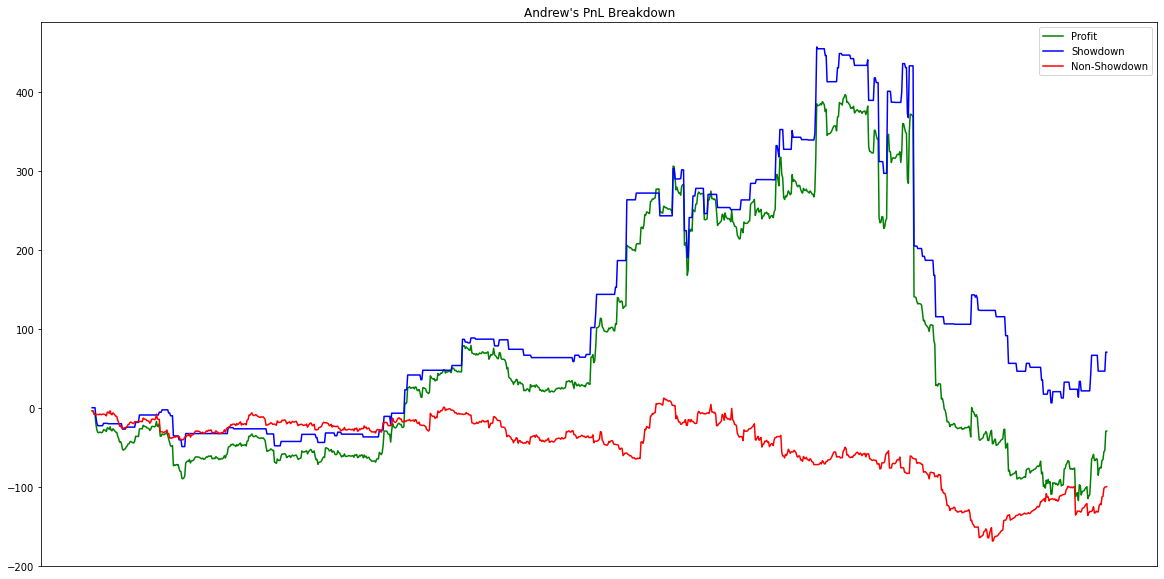

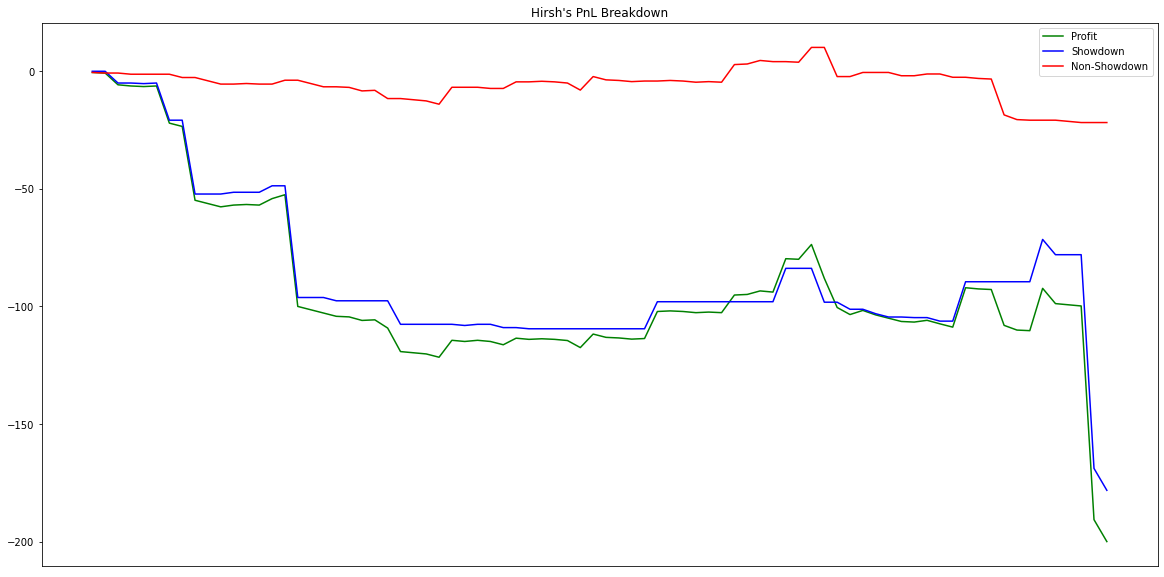

KeyError: 't'

In [6]:
hands = result.query("bet == bet and bet != 0 and hand_id == hand_id and street != ''")
betting_action = hands.drop_duplicates(["player", "session", "hand_id", "street"], keep="last").round(2)
profits = betting_action.groupby(["session", "hand_id", "player"], as_index=False).agg({"bet": "sum", "at": "last"}).sort_values("at")
pd.pivot_table(profits, index=["session", "hand_id"], columns="player").bet.fillna(0).cumsum().plot(figsize=(20, 10))
plt.xticks([])
plt.title("Total PnL")
plt.savefig(os.path.join(img_dir, "total_pnl.png"))
plt.show()

profits = profits.groupby(["session", "player"], as_index=False).agg({"bet": "sum", "at": "last"}).sort_values("at")
profits.session = profits.session.map(remap)
profits = pd.pivot_table(profits, index=["session"], columns="player").bet.fillna(0)
print("Profit by session (note dates are based on UTC)")
display(profits)
print()
print("Cumulative Profit by session")
display(profits.cumsum())

hands = result.query("bet == bet and bet != 0 and hand_id == hand_id and street != '' and showdown")
betting_action = hands.drop_duplicates(["player", "session", "hand_id", "street"], keep="last").round(2)
profits = betting_action.groupby(["session", "hand_id", "player"], as_index=False).agg({"bet": "sum", "at": "last"}).sort_values("at")
pd.pivot_table(profits, index=["at"], columns="player").bet.fillna(0).cumsum().reset_index().drop("at", axis=1).plot(figsize=(20, 10))
plt.xticks([])
plt.title("Showdown PnL")
plt.savefig(os.path.join(img_dir, "showdown_pnl.png"))
plt.show()

hands = result.query("bet == bet and bet != 0 and hand_id == hand_id and street != '' and not showdown")
betting_action = hands.drop_duplicates(["player", "session", "hand_id", "street"], keep="last").round(2)
profits = betting_action.groupby(["session", "hand_id", "player"], as_index=False).agg({"bet": "sum", "at": "last"}).sort_values("at")
pd.pivot_table(profits, index=["at"], columns="player").bet.fillna(0).cumsum().reset_index().drop("at", axis=1).plot(figsize=(20, 10))
plt.xticks([])
plt.title("Non-Showdown PnL")
plt.savefig(os.path.join(img_dir, "non_showdown_pnl.png"))
plt.show()

for player in result.player.dropna().unique():
    hands = result.query("bet == bet and bet != 0 and hand_id == hand_id and street != ''")
    betting_action = hands.drop_duplicates(["player", "session", "hand_id", "street"], keep="last").round(2)
    profits = betting_action.groupby(["session", "hand_id", "player"], as_index=False).agg({"bet": "sum", "at": "last", "showdown": "last"})
    showdown = pd.pivot_table(profits, index="at", columns="player").showdown[player].astype(float).dropna().sort_index()
    total = pd.pivot_table(profits, index="at", columns="player").bet[player].dropna().sort_index()
    sd = total.copy()
    nsd = total.copy()
    sd.loc[showdown == 0] = None
    sd = sd.reset_index()
    sd[player] = sd[player].fillna(0).cumsum()
    nsd.loc[showdown == 1] = None
    nsd = nsd.reset_index()
    nsd[player] = nsd[player].fillna(0).cumsum()
    total = total.reset_index()
    total[player] = total[player].fillna(0).cumsum()
    a = total.plot(y=player, color="g", figsize=(20, 10), label="Profit")
    sd.plot(y=player, color="b", ax=a, label="Showdown")
    nsd.plot(y=player, color="r", ax=a, label="Non-Showdown")
    plt.xticks([])
    plt.title(f"{player.capitalize()}'s PnL Breakdown")
    plt.savefig(os.path.join(graph_dir, f"{player}_pnl.png"))
    plt.show()


def print_big_hands(d):
# d = "2021-02-02"
    big_hands = result.query("date == @d and street == 'result' and bet >= 50")
    for _, row in big_hands.iterrows():
        s = row.session
        h = row.hand_id
        log = result.query("session == @s and hand_id == @h")
        display(log[["entry"]])


def print_preflop_ratios():
    pre = result.query("bet == bet and hand_id == hand_id and street == 'pre'")
    stats = []
    for p, pg in pre.groupby("player"):
        pg = pg[
            ~pg.entry.str.contains("collect") 
            & ~pg.entry.str.contains("uncalled")
            & ~pg.entry.str.contains("blinds")
        ]
        last_action = pg.groupby(["session", "hand_id"]).last()
        total_hands = len(last_action)
        last_action = pg.query("bet != 0").groupby(["session", "hand_id"]).last()

        calls = last_action[last_action.entry.str.contains("calls")]
        raises = last_action[last_action.entry.str.contains("bets|raises", regex=True)]
        data = {"player": p, "PFR": len(raises) / total_hands, "VPIP": (len(calls) + len(raises)) / total_hands}
        stats.append(data)
    stat_df = pd.DataFrame(stats)
    stat_df["PFR/VPIP"] = stat_df.eval("PFR / VPIP")
    display(stat_df.round(2))

In [26]:
print_preflop_ratios()

player   PFR  VPIP  PFR/VPIP
0   aditya     0.18  0.46  0.39    
1   alan       0.29  0.47  0.61    
2   alex       0.23  0.56  0.41    
3   andrew     0.21  0.54  0.39    
4   carter     0.36  0.58  0.62    
5   daniel     0.15  0.37  0.42    
6   danny      0.19  0.36  0.54    
7   grace      0.12  0.34  0.35    
8   herry      0.11  0.26  0.41    
9   hersh      0.26  0.48  0.54    
10  jarry      0.41  0.61  0.66    
11  json       0.20  0.38  0.52    
12  justin     0.11  0.33  0.34    
13  kensworth  0.13  0.29  0.45    
14  matthew    0.34  0.49  0.69    
15  michael    0.26  0.48  0.54    
16  pat        0.07  0.41  0.17    
17  rob        0.07  0.42  0.17    
18  sam        0.34  0.57  0.60    
19  simon      0.20  0.59  0.35

In [16]:
session = "4wdL7w_BCc83hclpBqX4yaMvt"
currgame = result.query("session == @session")

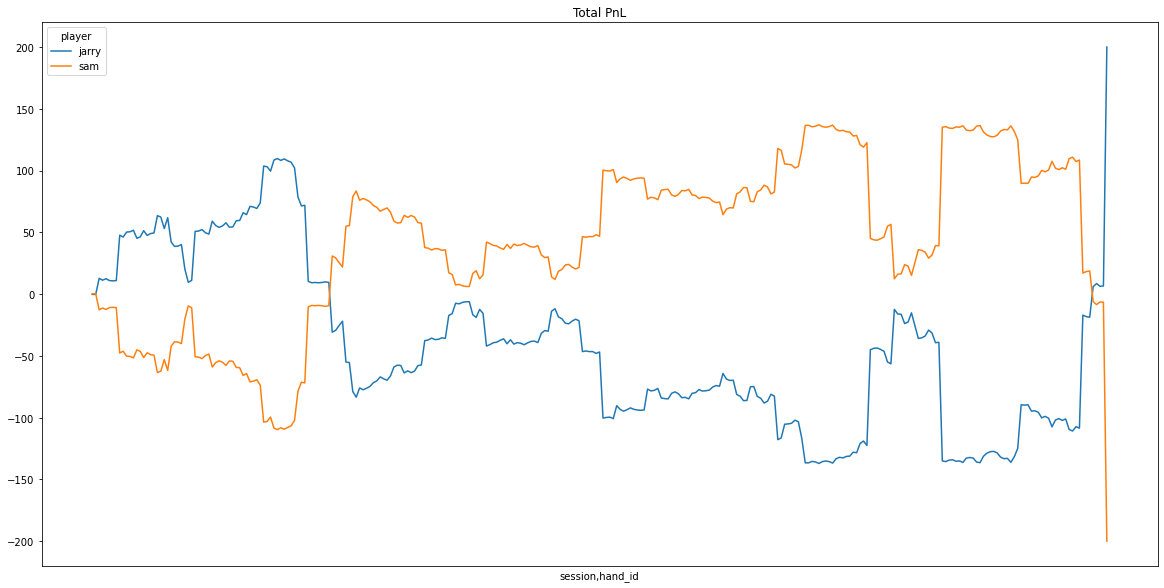

2021-05-02,Jarry,200.0
2021-05-02,Sam,-200.0
Profit by session (note dates are based on UTC)


player      jarry    sam
session                 
2021-05-02  200.0 -200.0


Cumulative Profit by session


player      jarry    sam
session                 
2021-05-02  200.0 -200.0

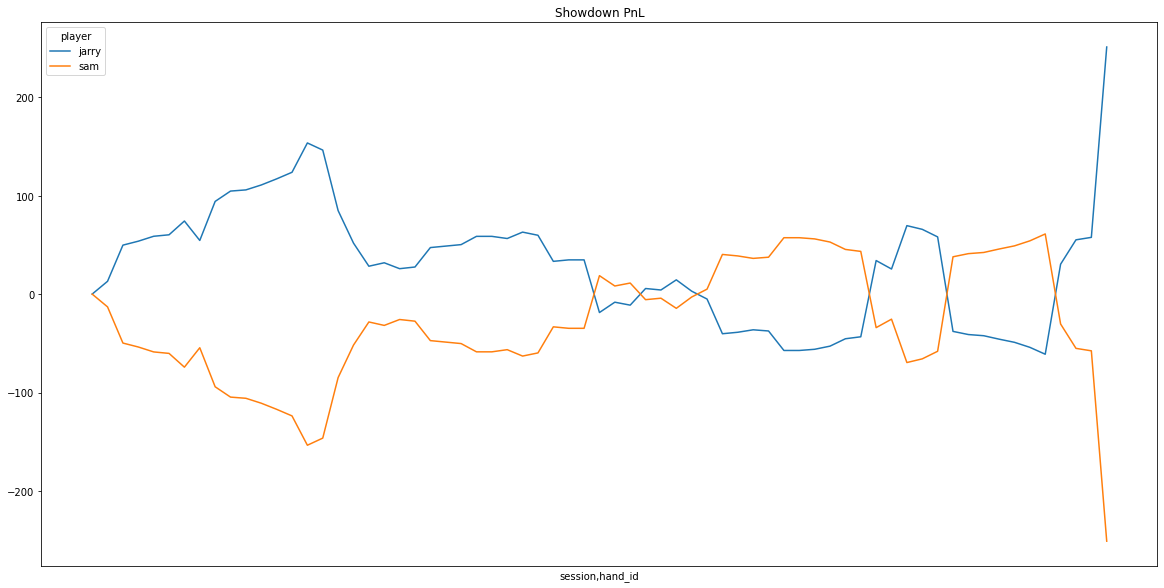

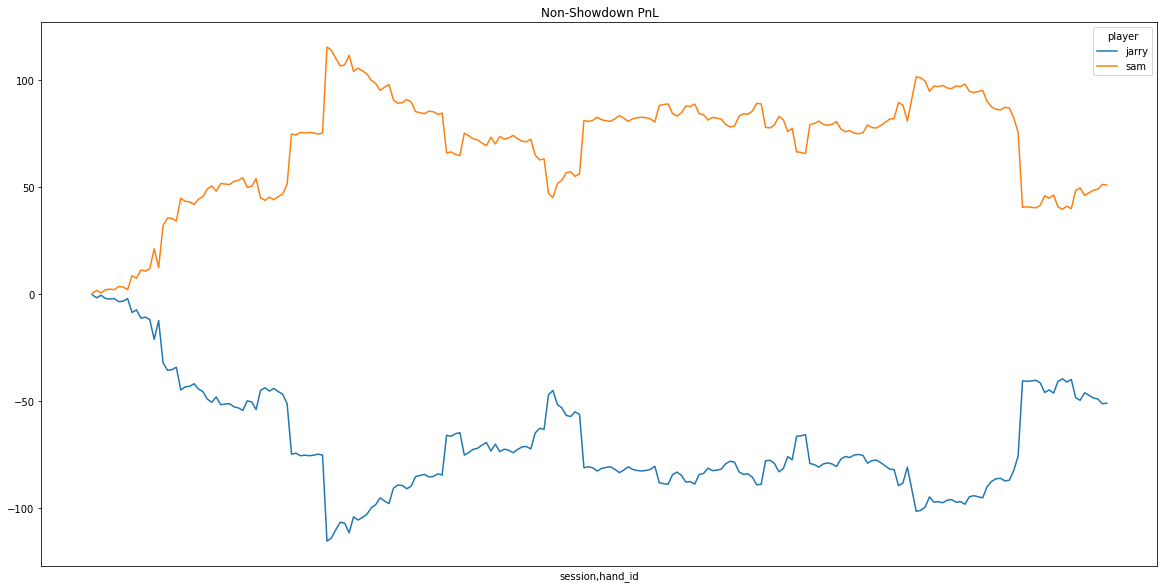

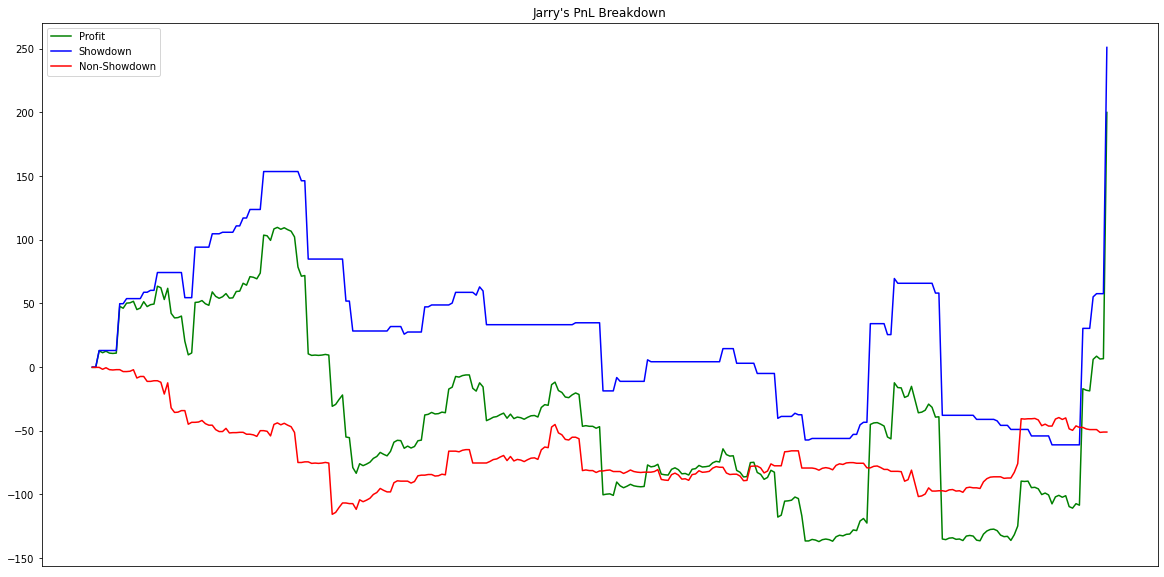

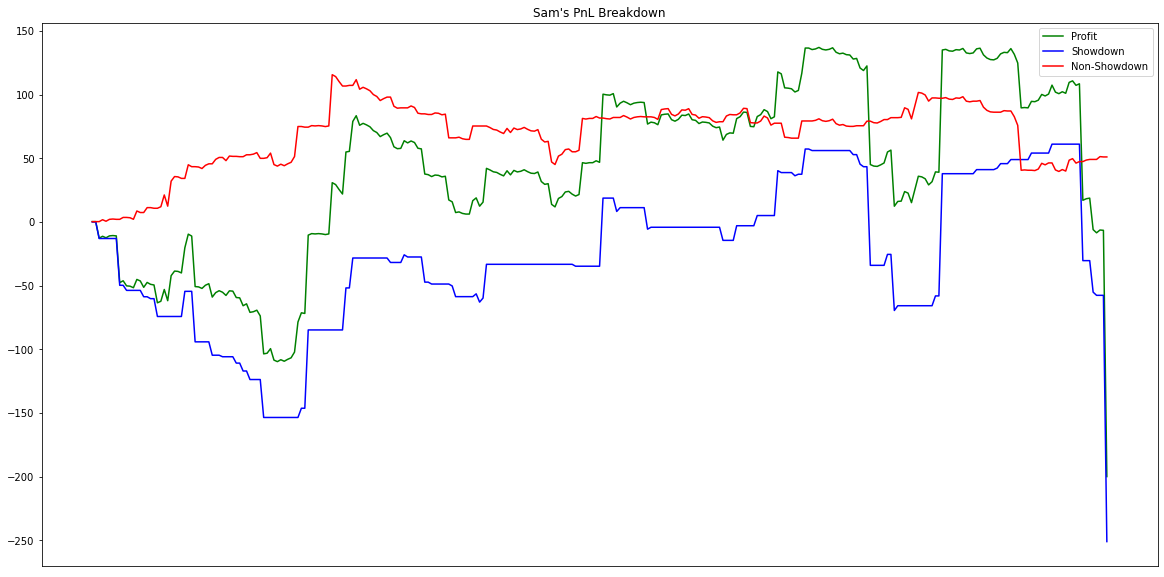

In [19]:
s = pd.to_datetime("2021-04-17").tz_localize("UTC")
# currgame = result.query("at > @s")
hands = currgame.query("bet == bet and bet != 0 and hand_id == hand_id and street != ''")
betting_action = hands.drop_duplicates(["player", "session", "hand_id", "street"], keep="last").round(2)
profits = betting_action.groupby(["session", "hand_id", "player"], as_index=False).agg({"bet": "sum", "at": "last"}).sort_values("at")


pd.pivot_table(profits, index=["session", "hand_id"], columns="player").bet.fillna(0).cumsum().plot(figsize=(20, 10))
plt.xticks([])
plt.title("Total PnL")
plt.show()
res = pd.pivot_table(profits, index=["session", "hand_id"], columns="player").bet.fillna(0).cumsum()
for p, row in (res.tail(1).T.iterrows()):
    row = row.round(2)
    print(",".join(list(map(str, [session_map[session], p.capitalize(), row.iloc[0]]))))


profits = profits.groupby(["session", "player"], as_index=False).agg({"bet": "sum", "at": "last"}).sort_values("at")
profits.session = profits.session.map(remap)
profits = pd.pivot_table(profits, index=["session"], columns="player").bet.fillna(0)
print("Profit by session (note dates are based on UTC)")
display(profits)
print()
print("Cumulative Profit by session")
display(profits.cumsum())

hands = currgame.query("bet == bet and bet != 0 and hand_id == hand_id and street != '' and showdown")
betting_action = hands.drop_duplicates(["player", "session", "hand_id", "street"], keep="last").round(2)
profits = betting_action.groupby(["session", "hand_id", "player"], as_index=False).agg({"bet": "sum", "at": "last"}).sort_values("at")
pd.pivot_table(profits, index=["session", "hand_id"], columns="player").bet.fillna(0).cumsum().plot(figsize=(20, 10))
plt.xticks([])
plt.title("Showdown PnL")
plt.show()

hands = currgame.query("bet == bet and bet != 0 and hand_id == hand_id and street != '' and not showdown")
betting_action = hands.drop_duplicates(["player", "session", "hand_id", "street"], keep="last").round(2)
profits = betting_action.groupby(["session", "hand_id", "player"], as_index=False).agg({"bet": "sum", "at": "last"}).sort_values("at")
# display(profits.head(50))
pd.pivot_table(profits, index=["session", "hand_id"], columns="player").bet.fillna(0).cumsum().plot(figsize=(20, 10))
plt.xticks([])
plt.title("Non-Showdown PnL")
plt.show()

for player in currgame.player.dropna().unique():
    hands = currgame.query("bet == bet and bet != 0 and hand_id == hand_id and street != ''")
    betting_action = hands.drop_duplicates(["player", "session", "hand_id", "street"], keep="last").round(2)
    profits = betting_action.groupby(["session", "hand_id", "player"], as_index=False).agg({"bet": "sum", "at": "last", "showdown": "last"})
    showdown = pd.pivot_table(profits, index="at", columns="player").showdown[player].astype(float).dropna().sort_index()
    total = pd.pivot_table(profits, index="at", columns="player").bet[player].dropna().sort_index()
    sd = total.copy()
    nsd = total.copy()
    sd.loc[showdown == 0] = None
    sd = sd.reset_index()
    sd[player] = sd[player].fillna(0).cumsum()
    nsd.loc[showdown == 1] = None
    nsd = nsd.reset_index()
    nsd[player] = nsd[player].fillna(0).cumsum()
    total = total.reset_index()
    total[player] = total[player].fillna(0).cumsum()
    a = total.plot(y=player, color="g", figsize=(20, 10), label="Profit")
    sd.plot(y=player, color="b", ax=a, label="Showdown")
    nsd.plot(y=player, color="r", ax=a, label="Non-Showdown")
    plt.xticks([])
    plt.title(f"{player.capitalize()}'s PnL Breakdown")
    plt.show()

In [20]:
pd.set_option('display.max_colwidth', None)
for h, s in currgame.query("abs(bet) > 50 and street == 'result'")[["hand_id", "session"]].drop_duplicates().values:
    display(currgame.query("hand_id == @h and session == @s")[["entry", "street"]].replace("", pd.NA).dropna(subset=["street"])[["entry"]])

entry
385108                 -- starting hand #31  (no limit texas hold'em) (dealer: jarry @ 1yx9cvwiik) --
385109                   player stacks: #1 jarry @ 1yx9cvwiik (111.09) | #6 sam @ ffxhtdi5wf (188.91)
385110                                                                            your hand is 9♥, 6♦
385111                                                 jarry @ 1yx9cvwiik posts a small blind of 0.25
385112                                                     sam @ ffxhtdi5wf posts a big blind of 0.50
385113                                                              jarry @ 1yx9cvwiik raises to 1.20
385114                                                                sam @ ffxhtdi5wf raises to 3.89
385115                                                                  jarry @ 1yx9cvwiik calls 3.89
385116                                                                           flop:  [6♣, 10♣, 5♦]
385117                                                                     sam @ ffxhtdi5wf bets 1.50
385118                                                                  jarry @ 1yx9cvwiik calls 1.50
385119                                                                         turn: 6♣, 10♣, 5♦ [8♦]
385120                                                                    sam @ ffxhtdi5wf bets 10.08
385121                                                                 jarry @ 1yx9cvwiik calls 10.08
385122                                                                    river: 6♣, 10♣, 5♦, 8♦ [3♥]
385123                                                                    sam @ ffxhtdi5wf bets 24.20
385124                                                                 jarry @ 1yx9cvwiik calls 24.20
385125                                                             jarry @ 1yx9cvwiik shows a 9♥, 6♦.
385126  jarry @ 1yx9cvwiik collected 79.34 from pot with pair, 6's (combination: 6♦, 6♣, 10♣, 9♥, 8♦)
385127                                                               sam @ ffxhtdi5wf shows a q♦, k♦.

entry
385245                      -- starting hand #9  (no limit texas hold'em) (dealer: jarry @ 1yx9cvwiik) --
385246                        player stacks: #1 jarry @ 1yx9cvwiik (110.95) | #6 sam @ ffxhtdi5wf (89.05)
385247                                                                                your hand is 7♦, j♦
385248                                                     jarry @ 1yx9cvwiik posts a small blind of 0.25
385249                                                         sam @ ffxhtdi5wf posts a big blind of 0.50
385250                                                                  jarry @ 1yx9cvwiik raises to 1.20
385251                                                                    sam @ ffxhtdi5wf raises to 3.80
385252                                                                      jarry @ 1yx9cvwiik calls 3.80
385253                                                                                flop:  [2♦, q♦, j♠]
385254                                                                            sam @ ffxhtdi5wf checks
385255                                                                          jarry @ 1yx9cvwiik checks
385256                                                                              turn: 2♦, q♦, j♠ [3♦]
385257                                                                            sam @ ffxhtdi5wf checks
385258                                                                       jarry @ 1yx9cvwiik bets 2.00
385259                                                                    sam @ ffxhtdi5wf raises to 7.50
385260                                                                      jarry @ 1yx9cvwiik calls 7.50
385261                                                                         river: 2♦, q♦, j♠, 3♦ [k♣]
385262                                                                        sam @ ffxhtdi5wf bets 25.45
385263                                                                     jarry @ 1yx9cvwiik calls 25.45
385264                                                                 jarry @ 1yx9cvwiik shows a 7♦, j♦.
385265  jarry @ 1yx9cvwiik collected 73.50 from pot with flush, qd high (combination: q♦, j♦, 7♦, 3♦, 2♦)
385266                                                                   sam @ ffxhtdi5wf shows a k♠, j♥.

entry
385923                          -- starting hand #51  (no limit texas hold'em) (dealer: jarry @ 1yx9cvwiik) --
385924                            player stacks: #1 jarry @ 1yx9cvwiik (173.81) | #6 sam @ ffxhtdi5wf (126.19)
385925                                                                                     your hand is 2♠, 3♠
385926                                                          jarry @ 1yx9cvwiik posts a small blind of 0.25
385927                                                              sam @ ffxhtdi5wf posts a big blind of 0.50
385928                                                                       jarry @ 1yx9cvwiik raises to 1.20
385929                                                                             sam @ ffxhtdi5wf calls 1.20
385930                                                                                     flop:  [2♥, q♦, j♣]
385931                                                                                 sam @ ffxhtdi5wf checks
385932                                                                            jarry @ 1yx9cvwiik bets 1.80
385933                                                                             sam @ ffxhtdi5wf calls 1.80
385934                                                                                   turn: 2♥, q♦, j♣ [3♣]
385935                                                                                 sam @ ffxhtdi5wf checks
385936                                                                            jarry @ 1yx9cvwiik bets 3.80
385937                                                                             sam @ ffxhtdi5wf calls 3.80
385938                                                                              river: 2♥, q♦, j♣, 3♣ [4♠]
385939                                                                                 sam @ ffxhtdi5wf checks
385940                                                                            jarry @ 1yx9cvwiik bets 8.00
385941                                                                        sam @ ffxhtdi5wf raises to 23.00
385942                                                                          jarry @ 1yx9cvwiik calls 23.00
385943                                                                      jarry @ 1yx9cvwiik shows a 2♠, 3♠.
385944  jarry @ 1yx9cvwiik collected 59.60 from pot with two pair, 3's & 2's (combination: 3♠, 3♣, 2♠, 2♥, q♦)
385945                                                                        sam @ ffxhtdi5wf shows a q♥, 6♣.

entry
386126                      -- starting hand #64  (no limit texas hold'em) (dealer: sam @ ffxhtdi5wf) --
386127                      player stacks: #1 jarry @ 1yx9cvwiik (171.86) | #6 sam @ ffxhtdi5wf (128.14)
386128                                                                               your hand is j♦, q♣
386129                                                      sam @ ffxhtdi5wf posts a small blind of 0.25
386130                                                      jarry @ 1yx9cvwiik posts a big blind of 0.50
386131                                                                   sam @ ffxhtdi5wf raises to 1.50
386132                                                                 jarry @ 1yx9cvwiik raises to 4.50
386133                                                                       sam @ ffxhtdi5wf calls 4.50
386134                                                                               flop:  [q♠, 5♠, 7♥]
386135                                                                      jarry @ 1yx9cvwiik bets 6.00
386136                                                                       sam @ ffxhtdi5wf calls 6.00
386137                                                                             turn: q♠, 5♠, 7♥ [6♥]
386138                                                                         jarry @ 1yx9cvwiik checks
386139                                                                       sam @ ffxhtdi5wf bets 10.00
386140                                                                    jarry @ 1yx9cvwiik calls 10.00
386141                                                                        river: q♠, 5♠, 7♥, 6♥ [3♥]
386142                                                                         jarry @ 1yx9cvwiik checks
386143                                                                       sam @ ffxhtdi5wf bets 41.00
386144                                                                    jarry @ 1yx9cvwiik calls 41.00
386145                                                                  sam @ ffxhtdi5wf shows a 5♥, k♥.
386146  sam @ ffxhtdi5wf collected 123.00 from pot with flush, kh high (combination: k♥, 7♥, 6♥, 5♥, 3♥)

entry
386212  -- starting hand #71  (no limit texas hold'em) (dealer: jarry @ 1yx9cvwiik) --
386213    player stacks: #1 jarry @ 1yx9cvwiik (109.41) | #6 sam @ ffxhtdi5wf (190.59)
386214                                                             your hand is k♥, q♥
386215                                  jarry @ 1yx9cvwiik posts a small blind of 0.25
386216                                      sam @ ffxhtdi5wf posts a big blind of 0.50
386217                                               jarry @ 1yx9cvwiik raises to 1.20
386218                                                 sam @ ffxhtdi5wf raises to 3.90
386219                                                   jarry @ 1yx9cvwiik calls 3.90
386220                                                             flop:  [k♣, 4♦, 4♠]
386221                                                         sam @ ffxhtdi5wf checks
386222                                                    jarry @ 1yx9cvwiik bets 2.00
386223                                                     sam @ ffxhtdi5wf calls 2.00
386224                                                           turn: k♣, 4♦, 4♠ [j♠]
386225                                                         sam @ ffxhtdi5wf checks
386226                                                   jarry @ 1yx9cvwiik bets 11.80
386227                                                sam @ ffxhtdi5wf raises to 34.35
386228                                                  jarry @ 1yx9cvwiik calls 34.35
386229                                                      river: k♣, 4♦, 4♠, j♠ [a♦]
386230                                       sam @ ffxhtdi5wf bets 69.16 and go all in
386231                                                        jarry @ 1yx9cvwiik folds
386232                              uncalled bet of 69.16 returned to sam @ ffxhtdi5wf
386233                                       sam @ ffxhtdi5wf collected 80.50 from pot

entry
386289                     -- starting hand #75  (no limit texas hold'em) (dealer: jarry @ 1yx9cvwiik) --
386290                       player stacks: #1 jarry @ 1yx9cvwiik (178.06) | #6 sam @ ffxhtdi5wf (221.94)
386291                                                                                your hand is 2♣, a♥
386292                                                     jarry @ 1yx9cvwiik posts a small blind of 0.25
386293                                                         sam @ ffxhtdi5wf posts a big blind of 0.50
386294                                                                  jarry @ 1yx9cvwiik raises to 1.20
386295                                                                        sam @ ffxhtdi5wf calls 1.20
386296                                                                               flop:  [10♥, 4♣, j♥]
386297                                                                            sam @ ffxhtdi5wf checks
386298                                                                          jarry @ 1yx9cvwiik checks
386299                                                                             turn: 10♥, 4♣, j♥ [6♣]
386300                                                                            sam @ ffxhtdi5wf checks
386301                                                                       jarry @ 1yx9cvwiik bets 1.80
386302                                                                    sam @ ffxhtdi5wf raises to 7.80
386303                                                                      jarry @ 1yx9cvwiik calls 7.80
386304                                                                        river: 10♥, 4♣, j♥, 6♣ [2♠]
386305                                                                        sam @ ffxhtdi5wf bets 24.00
386306                                                                     jarry @ 1yx9cvwiik calls 24.00
386307                                                                   sam @ ffxhtdi5wf shows a 3♥, 5♠.
386308  sam @ ffxhtdi5wf collected 66.00 from pot with straight, 6 high (combination: 6♣, 5♠, 4♣, 3♥, 2♠)

entry
386964                            -- starting hand #116  (no limit texas hold'em) (dealer: sam @ ffxhtdi5wf) --
386965                             player stacks: #1 jarry @ 1yx9cvwiik (184.41) | #6 sam @ ffxhtdi5wf (215.59)
386966                                                                                      your hand is 6♦, k♣
386967                                                             sam @ ffxhtdi5wf posts a small blind of 0.25
386968                                                             jarry @ 1yx9cvwiik posts a big blind of 0.50
386969                                                                          sam @ ffxhtdi5wf raises to 1.50
386970                                                                            jarry @ 1yx9cvwiik calls 1.50
386971                                                                                     flop:  [6♠, q♣, 10♣]
386972                                                                                jarry @ 1yx9cvwiik checks
386973                                                                                  sam @ ffxhtdi5wf checks
386974                                                                                   turn: 6♠, q♣, 10♣ [j♦]
386975                                                                             jarry @ 1yx9cvwiik bets 2.00
386976                                                                          sam @ ffxhtdi5wf raises to 5.00
386977                                                                            jarry @ 1yx9cvwiik calls 5.00
386978                                                                             river: 6♠, q♣, 10♣, j♦ [10♦]
386979                                                                                jarry @ 1yx9cvwiik checks
386980                                                                               sam @ ffxhtdi5wf bets 6.50
386981                                                                       jarry @ 1yx9cvwiik raises to 20.00
386982                                                                             sam @ ffxhtdi5wf calls 20.00
386983                                                                         sam @ ffxhtdi5wf shows a 4♣, q♠.
386984  sam @ ffxhtdi5wf collected 53.00 from pot with two pair, q's & 10's (combination: q♠, q♣, 10♣, 10♦, j♦)
386985                                                                       jarry @ 1yx9cvwiik shows a 6♦, k♣.

entry
387473                          -- starting hand #150  (no limit texas hold'em) (dealer: sam @ ffxhtdi5wf) --
387474                           player stacks: #1 jarry @ 1yx9cvwiik (153.16) | #6 sam @ ffxhtdi5wf (246.84)
387475                                                                                    your hand is a♦, 3♥
387476                                                           sam @ ffxhtdi5wf posts a small blind of 0.25
387477                                                           jarry @ 1yx9cvwiik posts a big blind of 0.50
387478                                                                        sam @ ffxhtdi5wf raises to 1.50
387479                                                                          jarry @ 1yx9cvwiik calls 1.50
387480                                                                                    flop:  [9♣, 2♠, 4♦]
387481                                                                              jarry @ 1yx9cvwiik checks
387482                                                                                sam @ ffxhtdi5wf checks
387483                                                                                  turn: 9♣, 2♠, 4♦ [7♣]
387484                                                                           jarry @ 1yx9cvwiik bets 2.00
387485                                                                        sam @ ffxhtdi5wf raises to 7.00
387486                                                                          jarry @ 1yx9cvwiik calls 7.00
387487                                                                             river: 9♣, 2♠, 4♦, 7♣ [3♠]
387488                                                                              jarry @ 1yx9cvwiik checks
387489                                                                            sam @ ffxhtdi5wf bets 15.25
387490                                                                     jarry @ 1yx9cvwiik raises to 45.00
387491                                                                           sam @ ffxhtdi5wf calls 45.00
387492                                                                       sam @ ffxhtdi5wf shows a 9♥, 7♥.
387493  sam @ ffxhtdi5wf collected 107.00 from pot with two pair, 9's & 7's (combination: 9♥, 9♣, 7♥, 7♣, 4♦)
387494                                                                     jarry @ 1yx9cvwiik shows a a♦, 3♥.

entry
388205                     -- starting hand #201  (no limit texas hold'em) (dealer: jarry @ 1yx9cvwiik) --
388206                        player stacks: #1 jarry @ 1yx9cvwiik (117.41) | #6 sam @ ffxhtdi5wf (282.59)
388207                                                                                 your hand is q♥, 4♦
388208                                                      jarry @ 1yx9cvwiik posts a small blind of 0.25
388209                                                          sam @ ffxhtdi5wf posts a big blind of 0.50
388210                                                                   jarry @ 1yx9cvwiik raises to 1.20
388211                                                                         sam @ ffxhtdi5wf calls 1.20
388212                                                                                 flop:  [q♦, j♠, 2♦]
388213                                                                             sam @ ffxhtdi5wf checks
388214                                                                        jarry @ 1yx9cvwiik bets 1.00
388215                                                                         sam @ ffxhtdi5wf calls 1.00
388216                                                                               turn: q♦, j♠, 2♦ [8♣]
388217                                                                             sam @ ffxhtdi5wf checks
388218                                                                        jarry @ 1yx9cvwiik bets 1.30
388219                                                                     sam @ ffxhtdi5wf raises to 7.05
388220                                                                       jarry @ 1yx9cvwiik calls 7.05
388221                                                                          river: q♦, j♠, 2♦, 8♣ [k♣]
388222                                                                         sam @ ffxhtdi5wf bets 26.00
388223                                                                      jarry @ 1yx9cvwiik calls 26.00
388224                                                                   sam @ ffxhtdi5wf shows a 9♠, 10♥.
388225  sam @ ffxhtdi5wf collected 70.50 from pot with straight, k high (combination: k♣, q♦, j♠, 10♥, 9♠)

entry
388360                                -- starting hand #210  (no limit texas hold'em) (dealer: sam @ ffxhtdi5wf) --
388361                                  player stacks: #1 jarry @ 1yx9cvwiik (63.41) | #6 sam @ ffxhtdi5wf (336.59)
388362                                                                                          your hand is j♥, 6♣
388363                                                                 sam @ ffxhtdi5wf posts a small blind of 0.25
388364                                                                 jarry @ 1yx9cvwiik posts a big blind of 0.50
388365                                                                              sam @ ffxhtdi5wf raises to 1.50
388366                                                                                jarry @ 1yx9cvwiik calls 1.50
388367                                                                                          flop:  [j♦, 7♥, 3♥]
388368                                                                                    jarry @ 1yx9cvwiik checks
388369                                                                                   sam @ ffxhtdi5wf bets 2.25
388370                                                                                jarry @ 1yx9cvwiik calls 2.25
388371                                                                                        turn: j♦, 7♥, 3♥ [j♠]
388372                                                                                 jarry @ 1yx9cvwiik bets 5.00
388373                                                                                  sam @ ffxhtdi5wf calls 5.00
388374                                                                                   river: j♦, 7♥, 3♥, j♠ [7♦]
388375                                                                                jarry @ 1yx9cvwiik bets 23.00
388376                                                               sam @ ffxhtdi5wf raises to 54.66 and go all in
388377                                                                 jarry @ 1yx9cvwiik calls 54.66 and go all in
388378                                                                           jarry @ 1yx9cvwiik shows a j♥, 6♣.
388379  jarry @ 1yx9cvwiik collected 63.41 from pot with full house, j's over 7's (combination: j♥, j♦, j♠, 7♥, 7♦)
388380                                                                             sam @ ffxhtdi5wf shows a j♣, k♠.
388381    sam @ ffxhtdi5wf collected 63.41 from pot with full house, j's over 7's (combination: j♣, j♦, j♠, 7♥, 7♦)

entry
388635                            -- starting hand #228  (no limit texas hold'em) (dealer: sam @ ffxhtdi5wf) --
388636                              player stacks: #1 jarry @ 1yx9cvwiik (77.46) | #6 sam @ ffxhtdi5wf (322.54)
388637                                                                                      your hand is k♥, 2♥
388638                                                             sam @ ffxhtdi5wf posts a small blind of 0.25
388639                                                             jarry @ 1yx9cvwiik posts a big blind of 0.50
388640                                                                          sam @ ffxhtdi5wf raises to 1.50
388641                                                                        jarry @ 1yx9cvwiik raises to 4.50
388642                                                                              sam @ ffxhtdi5wf calls 4.50
388643                                                                                      flop:  [6♦, 5♥, 4♦]
388644                                                                             jarry @ 1yx9cvwiik bets 6.00
388645                                                                         sam @ ffxhtdi5wf raises to 22.75
388646                                                         jarry @ 1yx9cvwiik raises to 72.96 and go all in
388647                                                                             sam @ ffxhtdi5wf calls 72.96
388648                                                                       jarry @ 1yx9cvwiik shows a k♥, 2♥.
388649                                                                         sam @ ffxhtdi5wf shows a 7♦, 9♦.
388650                                                                                    turn: 6♦, 5♥, 4♦ [4♠]
388651                                                                               river: 6♦, 5♥, 4♦, 4♠ [2♠]
388652  jarry @ 1yx9cvwiik collected 154.92 from pot with two pair, 4's & 2's (combination: 4♦, 4♠, 2♥, 2♠, k♥)

entry
388747                            -- starting hand #235  (no limit texas hold'em) (dealer: jarry @ 1yx9cvwiik) --
388748                               player stacks: #1 jarry @ 1yx9cvwiik (143.57) | #6 sam @ ffxhtdi5wf (256.43)
388749                                                                                       your hand is 8♣, 10♣
388750                                                             jarry @ 1yx9cvwiik posts a small blind of 0.25
388751                                                                 sam @ ffxhtdi5wf posts a big blind of 0.50
388752                                                                          jarry @ 1yx9cvwiik raises to 1.20
388753                                                                            sam @ ffxhtdi5wf raises to 3.60
388754                                                                              jarry @ 1yx9cvwiik calls 3.60
388755                                                                                       flop:  [10♠, k♠, 8♥]
388756                                                                                 sam @ ffxhtdi5wf bets 3.00
388757                                                                         jarry @ 1yx9cvwiik raises to 10.00
388758                                                                               sam @ ffxhtdi5wf calls 10.00
388759                                                                                     turn: 10♠, k♠, 8♥ [2♥]
388760                                                                                    sam @ ffxhtdi5wf checks
388761                                                                              jarry @ 1yx9cvwiik bets 18.88
388762                                                                               sam @ ffxhtdi5wf calls 18.88
388763                                                                                river: 10♠, k♠, 8♥, 2♥ [q♦]
388764                                                                                    sam @ ffxhtdi5wf checks
388765                                                                              jarry @ 1yx9cvwiik bets 11.59
388766                                                                               sam @ ffxhtdi5wf calls 11.59
388767                                                                        jarry @ 1yx9cvwiik shows a 8♣, 10♣.
388768  jarry @ 1yx9cvwiik collected 88.14 from pot with two pair, 10's & 8's (combination: 10♣, 10♠, 8♣, 8♥, k♠)

entry
388984                    -- starting hand #249  (no limit texas hold'em) (dealer: jarry @ 1yx9cvwiik) --
388985                       player stacks: #1 jarry @ 1yx9cvwiik (160.94) | #6 sam @ ffxhtdi5wf (239.06)
388986                                                                                your hand is 9♦, 9♥
388987                                                     jarry @ 1yx9cvwiik posts a small blind of 0.25
388988                                                         sam @ ffxhtdi5wf posts a big blind of 0.50
388989                                                                  jarry @ 1yx9cvwiik raises to 1.20
388990                                                                    sam @ ffxhtdi5wf raises to 4.00
388991                                                                      jarry @ 1yx9cvwiik calls 4.00
388992                                                                               flop:  [k♠, j♥, 10♥]
388993                                                                            sam @ ffxhtdi5wf checks
388994                                                                          jarry @ 1yx9cvwiik checks
388995                                                                             turn: k♠, j♥, 10♥ [8♥]
388996                                                                         sam @ ffxhtdi5wf bets 8.00
388997                                                                      jarry @ 1yx9cvwiik calls 8.00
388998                                                                       river: k♠, j♥, 10♥, 8♥ [10♦]
388999                                                                        sam @ ffxhtdi5wf bets 20.00
389000                                                                 jarry @ 1yx9cvwiik raises to 84.00
389001                                                                       sam @ ffxhtdi5wf calls 84.00
389002                                                                   sam @ ffxhtdi5wf shows a q♥, a♥.
389003  sam @ ffxhtdi5wf collected 192.00 from pot with flush, ah high (combination: a♥, q♥, j♥, 10♥, 8♥)
389004                                                                 jarry @ 1yx9cvwiik shows a 9♦, 9♥.

entry
389321  -- starting hand #272  (no limit texas hold'em) (dealer: sam @ ffxhtdi5wf) --
389322    player stacks: #1 jarry @ 1yx9cvwiik (75.14) | #6 sam @ ffxhtdi5wf (324.86)
389323                                                           your hand is a♥, 10♥
389324                                   sam @ ffxhtdi5wf posts a small blind of 0.25
389325                                   jarry @ 1yx9cvwiik posts a big blind of 0.50
389326                                                sam @ ffxhtdi5wf raises to 1.50
389327                                              jarry @ 1yx9cvwiik raises to 4.50
389328                                               sam @ ffxhtdi5wf raises to 14.50
389329                                                 jarry @ 1yx9cvwiik calls 14.50
389330                                                            flop:  [k♠, a♣, k♦]
389331                                                      jarry @ 1yx9cvwiik checks
389332                                                    sam @ ffxhtdi5wf bets 20.75
389333                               jarry @ 1yx9cvwiik raises to 60.64 and go all in
389334                                                         sam @ ffxhtdi5wf folds
389335                           uncalled bet of 39.89 returned to jarry @ 1yx9cvwiik
389336                                    jarry @ 1yx9cvwiik collected 70.50 from pot

entry
389598                        -- starting hand #290  (no limit texas hold'em) (dealer: sam @ ffxhtdi5wf) --
389599                          player stacks: #1 jarry @ 1yx9cvwiik (91.49) | #6 sam @ ffxhtdi5wf (308.51)
389600                                                                                 your hand is 9♣, 10♣
389601                                                         sam @ ffxhtdi5wf posts a small blind of 0.25
389602                                                         jarry @ 1yx9cvwiik posts a big blind of 0.50
389603                                                                      sam @ ffxhtdi5wf raises to 1.50
389604                                                                    jarry @ 1yx9cvwiik raises to 4.50
389605                                                                     sam @ ffxhtdi5wf raises to 13.00
389606                                                                       jarry @ 1yx9cvwiik calls 13.00
389607                                                                                  flop:  [5♣, 2♥, a♣]
389608                                                                            jarry @ 1yx9cvwiik checks
389609                                                                          sam @ ffxhtdi5wf bets 13.00
389610                                                                       jarry @ 1yx9cvwiik calls 13.00
389611                                                                                turn: 5♣, 2♥, a♣ [k♣]
389612                                                                            jarry @ 1yx9cvwiik checks
389613                                                                          sam @ ffxhtdi5wf bets 34.50
389614                                                     jarry @ 1yx9cvwiik raises to 65.49 and go all in
389615                                                                         sam @ ffxhtdi5wf calls 65.49
389616                                                                  jarry @ 1yx9cvwiik shows a 9♣, 10♣.
389617                                                                     sam @ ffxhtdi5wf shows a k♦, 9♠.
389618                                                                           river: 5♣, 2♥, a♣, k♣ [k♠]
389619  jarry @ 1yx9cvwiik collected 182.98 from pot with flush, ac high (combination: a♣, k♣, 10♣, 9♣, 5♣)

entry
389717                               -- starting hand #297  (no limit texas hold'em) (dealer: jarry @ 1yx9cvwiik) --
389718                                  player stacks: #1 jarry @ 1yx9cvwiik (206.58) | #6 sam @ ffxhtdi5wf (193.42)
389719                                                                                           your hand is 7♥, 9♥
389720                                                                jarry @ 1yx9cvwiik posts a small blind of 0.25
389721                                                                    sam @ ffxhtdi5wf posts a big blind of 0.50
389722                                                                             jarry @ 1yx9cvwiik raises to 1.20
389723                                                                               sam @ ffxhtdi5wf raises to 4.10
389724                                                                                 jarry @ 1yx9cvwiik calls 4.10
389725                                                                                           flop:  [3♥, 6♥, 7♦]
389726                                                                                    sam @ ffxhtdi5wf bets 8.20
389727                                                                                 jarry @ 1yx9cvwiik calls 8.20
389728                                                                                         turn: 3♥, 6♥, 7♦ [7♠]
389729                                                                                   sam @ ffxhtdi5wf bets 21.95
389730                                                                                jarry @ 1yx9cvwiik calls 21.95
389731                                                                                    river: 3♥, 6♥, 7♦, 7♠ [3♦]
389732                                                                                   sam @ ffxhtdi5wf bets 51.37
389733                                                             jarry @ 1yx9cvwiik raises to 159.17 and go all in
389734                                                                   sam @ ffxhtdi5wf calls 159.17 and go all in
389735                                                                            jarry @ 1yx9cvwiik shows a 7♥, 9♥.
389736  jarry @ 1yx9cvwiik collected 386.84 from pot with full house, 7's over 3's (combination: 7♥, 7♦, 7♠, 3♥, 3♦)
389737                                                                              sam @ ffxhtdi5wf shows a 6♣, 8♥.

In [10]:
player = "jarry"
hands = currgame.query("bet == bet and bet != 0 and hand_id == hand_id and street != ''")
betting_action = hands.drop_duplicates(["player", "session", "hand_id", "street"], keep="last").round(2)
profits = betting_action.groupby(["session", "hand_id", "player"], as_index=False).agg({"bet": "sum", "at": "last", "showdown": "last"})
showdown = pd.pivot_table(profits, index=["session", "hand_id"], columns="player").showdown[player].astype(float).dropna().sort_index()
total = pd.pivot_table(profits, index=["session", "hand_id"], columns="player").bet[player].dropna().sort_index()
sd = total.copy()
nsd = total.copy()
sd.loc[showdown == 0] = None
sd = sd.reset_index()
sd[player] = sd[player].fillna(0)
nsd.loc[showdown == 1] = None
nsd = nsd.reset_index()
nsd[player] = nsd[player].fillna(0)
total = total.reset_index()
total[player] = total[player].fillna(0)
big_sd_losses = sd[sd[player] < -50][["session", "hand_id"]].drop_duplicates().values
big_nsd_losses = nsd[nsd[player] < -50][["session", "hand_id"]].drop_duplicates().values

print("SHOWDOWN")
for s, h in big_sd_losses:
    display(result.query("hand_id == @h and session == @s")[["date", "entry", "street"]].replace("", pd.NA).dropna(subset=["street"]).set_index("date")[["entry"]])
print("NON-SHOWDOWN")
for s, h in big_nsd_losses:
    display(result.query("hand_id == @h and session == @s")[["date", "entry", "street"]].replace("", pd.NA).dropna(subset=["street"]).set_index("date")[["entry"]])

SHOWDOWN


entry
date                                                                                                                  
2021-04-11  -- starting hand #33  (no limit texas hold'em) (dealer: jarry @ fnp1l32ss8) --                            
2021-04-11  player stacks: #1 jarry @ fnp1l32ss8 (120.29) | #2 mh @ pndt6afnir (58.54) | #10 alex @ nbbslbauti (71.17)
2021-04-11  mh @ pndt6afnir posts a small blind of 0.25                                                               
2021-04-11  alex @ nbbslbauti posts a big blind of 0.50                                                               
2021-04-11  jarry @ fnp1l32ss8 raises to 1.12                                                                         
2021-04-11  mh @ pndt6afnir folds                                                                                     
2021-04-11  alex @ nbbslbauti raises to 4.11                                                                          
2021-04-11  jarry @ fnp1l32ss8 calls 4.11                                                                             
2021-04-11  flop:  [10♠, 9♠, q♠]                                                                                      
2021-04-11  alex @ nbbslbauti checks                                                                                  
2021-04-11  jarry @ fnp1l32ss8 bets 8.47                                                                              
2021-04-11  alex @ nbbslbauti calls 8.47                                                                              
2021-04-11  turn: 10♠, 9♠, q♠ [8♥]                                                                                    
2021-04-11  alex @ nbbslbauti checks                                                                                  
2021-04-11  jarry @ fnp1l32ss8 bets 11.20                                                                             
2021-04-11  alex @ nbbslbauti calls 11.20                                                                             
2021-04-11  river: 10♠, 9♠, q♠, 8♥ [a♦]                                                                               
2021-04-11  alex @ nbbslbauti checks                                                                                  
2021-04-11  jarry @ fnp1l32ss8 bets 11.83                                                                             
2021-04-11  alex @ nbbslbauti raises to 24.66                                                                         
2021-04-11  jarry @ fnp1l32ss8 raises to 47.39 and go all in                                                          
2021-04-11  alex @ nbbslbauti calls 47.39 and go all in                                                               
2021-04-11  alex @ nbbslbauti shows a 8♠, a♠.                                                                         
2021-04-11  alex @ nbbslbauti collected 142.59 from pot with flush, as high (combination: a♠, q♠, 10♠, 9♠, 8♠)        
2021-04-11  jarry @ fnp1l32ss8 shows a 6♠, 5♠.

entry
date                                                                                                                   
2021-04-12  -- starting hand #133  (no limit texas hold'em) (dealer: jarry @ vuqgqzroy1) --                            
2021-04-12  player stacks: #1 jarry @ vuqgqzroy1 (314.01) | #2 alex @ nbbslbauti (89.14) | #3 alan @ zwgfzqhosu (60.57)
2021-04-12  your hand is k♠, a♠                                                                                        
2021-04-12  alex @ nbbslbauti posts a small blind of 0.25                                                              
2021-04-12  alan @ zwgfzqhosu posts a big blind of 0.50                                                                
2021-04-12  jarry @ vuqgqzroy1 raises to 1.20                                                                          
2021-04-12  alex @ nbbslbauti folds                                                                                    
2021-04-12  alan @ zwgfzqhosu raises to 4.00                                                                           
2021-04-12  jarry @ vuqgqzroy1 raises to 14.00                                                                         
2021-04-12  alan @ zwgfzqhosu raises to 60.57 and go all in                                                            
2021-04-12  jarry @ vuqgqzroy1 calls 60.57                                                                             
2021-04-12  jarry @ vuqgqzroy1 shows a k♠, a♠.                                                                         
2021-04-12  alan @ zwgfzqhosu shows a q♥, q♠.                                                                          
2021-04-12  flop:  [3♦, 6♥, 5♠]                                                                                        
2021-04-12  turn: 3♦, 6♥, 5♠ [7♣]                                                                                      
2021-04-12  river: 3♦, 6♥, 5♠, 7♣ [q♦]                                                                                 
2021-04-12  alan @ zwgfzqhosu collected 121.39 from pot with three of a kind, q's (combination: q♥, q♠, q♦, 7♣, 6♥)

entry
date                                                                                                            
2021-04-01  -- starting hand #224  (no limit texas hold'em) (dealer: sam @ ffxhtdi5wf) --                       
2021-04-01  player stacks: #1 jarry @ vuqgqzroy1 (282.10) | #2 sam @ ffxhtdi5wf (95.73)                         
2021-04-01  your hand is a♣, 2♠                                                                                 
2021-04-01  sam @ ffxhtdi5wf posts a small blind of 0.25                                                        
2021-04-01  jarry @ vuqgqzroy1 posts a big blind of 0.50                                                        
2021-04-01  sam @ ffxhtdi5wf raises to 1.50                                                                     
2021-04-01  jarry @ vuqgqzroy1 calls 1.50                                                                       
2021-04-01  flop:  [4♥, 8♥, a♦]                                                                                 
2021-04-01  jarry @ vuqgqzroy1 checks                                                                           
2021-04-01  sam @ ffxhtdi5wf bets 3.00                                                                          
2021-04-01  jarry @ vuqgqzroy1 calls 3.00                                                                       
2021-04-01  turn: 4♥, 8♥, a♦ [a♥]                                                                               
2021-04-01  jarry @ vuqgqzroy1 checks                                                                           
2021-04-01  sam @ ffxhtdi5wf bets 7.75                                                                          
2021-04-01  jarry @ vuqgqzroy1 calls 7.75                                                                       
2021-04-01  river: 4♥, 8♥, a♦, a♥ [k♥]                                                                          
2021-04-01  jarry @ vuqgqzroy1 checks                                                                           
2021-04-01  sam @ ffxhtdi5wf bets 9.75                                                                          
2021-04-01  jarry @ vuqgqzroy1 raises to 40.00                                                                  
2021-04-01  sam @ ffxhtdi5wf calls 40.00                                                                        
2021-04-01  sam @ ffxhtdi5wf shows a 7♥, 6♥.                                                                    
2021-04-01  sam @ ffxhtdi5wf collected 104.50 from pot with flush, ah high (combination: a♥, k♥, 8♥, 7♥, 6♥, 4♥)
2021-04-01  jarry @ vuqgqzroy1 shows a a♣, 2♠.

entry
date                                                                                                     
2021-04-04  -- starting hand #19  (no limit texas hold'em) (dealer: jarry @ vuqgqzroy1) --               
2021-04-04  player stacks: #1 jarry @ vuqgqzroy1 (149.98) | #3 alan @ zwgfzqhosu (90.02)                 
2021-04-04  your hand is a♠, k♠                                                                          
2021-04-04  jarry @ vuqgqzroy1 posts a small blind of 0.25                                               
2021-04-04  alan @ zwgfzqhosu posts a big blind of 0.50                                                  
2021-04-04  jarry @ vuqgqzroy1 raises to 1.30                                                            
2021-04-04  alan @ zwgfzqhosu raises to 4.40                                                             
2021-04-04  jarry @ vuqgqzroy1 raises to 14.00                                                           
2021-04-04  alan @ zwgfzqhosu raises to 29.99                                                            
2021-04-04  jarry @ vuqgqzroy1 raises to 149.98 and go all in                                            
2021-04-04  alan @ zwgfzqhosu calls 90.02 and go all in                                                  
2021-04-04  uncalled bet of 59.96 returned to jarry @ vuqgqzroy1                                         
2021-04-04  jarry @ vuqgqzroy1 shows a a♠, k♠.                                                           
2021-04-04  alan @ zwgfzqhosu shows a a♦, a♥.                                                            
2021-04-04  flop:  [10♣, 3♥, 6♠]                                                                         
2021-04-04  turn: 10♣, 3♥, 6♠ [8♥]                                                                       
2021-04-04  river: 10♣, 3♥, 6♠, 8♥ [j♠]                                                                  
2021-04-04  alan @ zwgfzqhosu collected 180.04 from pot with pair, a's (combination: a♦, a♥, j♠, 10♣, 8♥)

NON-SHOWDOWN


entry
date                                                                                      
2021-04-18  -- starting hand #25  (no limit texas hold'em) (dealer: jarry @ tuirz7tgtw) --
2021-04-18  player stacks: #1 jarry @ tuirz7tgtw (187.29) | #6 sam @ ffxhtdi5wf (162.71)  
2021-04-18  jarry @ tuirz7tgtw posts a small blind of 0.25                                
2021-04-18  sam @ ffxhtdi5wf posts a big blind of 0.50                                    
2021-04-18  jarry @ tuirz7tgtw raises to 1.20                                             
2021-04-18  sam @ ffxhtdi5wf raises to 3.60                                               
2021-04-18  jarry @ tuirz7tgtw calls 3.60                                                 
2021-04-18  flop:  [10♣, k♥, k♣]                                                          
2021-04-18  sam @ ffxhtdi5wf bets 4.90                                                    
2021-04-18  jarry @ tuirz7tgtw calls 4.90                                                 
2021-04-18  turn: 10♣, k♥, k♣ [10♦]                                                       
2021-04-18  sam @ ffxhtdi5wf checks                                                       
2021-04-18  jarry @ tuirz7tgtw bets 3.00                                                  
2021-04-18  sam @ ffxhtdi5wf raises to 17.00                                              
2021-04-18  jarry @ tuirz7tgtw raises to 50.00                                            
2021-04-18  sam @ ffxhtdi5wf raises to 154.21 and go all in                               
2021-04-18  jarry @ tuirz7tgtw folds                                                      
2021-04-18  uncalled bet of 104.21 returned to sam @ ffxhtdi5wf                           
2021-04-18  sam @ ffxhtdi5wf collected 117.00 from pot

In [11]:
player = "jarry"
hands = currgame.query("bet == bet and bet != 0 and hand_id == hand_id and street != ''")
betting_action = hands.drop_duplicates(["player", "session", "hand_id", "street"], keep="last").round(2)
profits = betting_action.groupby(["session", "hand_id", "player"], as_index=False).agg({"bet": "sum", "at": "last", "showdown": "last"})
showdown = pd.pivot_table(profits, index=["session", "hand_id"], columns="player").showdown[player].astype(float).dropna().sort_index()
total = pd.pivot_table(profits, index=["session", "hand_id"], columns="player").bet[player].dropna().sort_index()
sd = total.copy()
nsd = total.copy()
sd.loc[showdown == 0] = None
sd = sd.reset_index()
sd[player] = sd[player].fillna(0)
nsd.loc[showdown == 1] = None
nsd = nsd.reset_index()
nsd[player] = nsd[player].fillna(0)
total = total.reset_index()
total[player] = total[player].fillna(0)
big_sd_losses = sd[sd[player] > 50][["session", "hand_id"]].drop_duplicates().values
big_nsd_losses = nsd[nsd[player] > 50][["session", "hand_id"]].drop_duplicates().values

for s, h in big_sd_losses:
    display(result.query("hand_id == @h and session == @s")[["date", "entry", "street"]].replace("", pd.NA).dropna(subset=["street"]).set_index("date")[["entry"]])
    
for s, h in big_nsd_losses:
    display(result.query("hand_id == @h and session == @s")[["date", "entry", "street"]].replace("", pd.NA).dropna(subset=["street"]).set_index("date")[["entry"]])

entry
date                                                                                                                                                      
2021-04-12  -- starting hand #66  (no limit texas hold'em) (dealer: alex @ nbbslbauti) --                                                                 
2021-04-12  player stacks: #1 jarry @ vuqgqzroy1 (169.54) | #2 alex @ nbbslbauti (115.86) | #3 alan @ zwgfzqhosu (45.57) | #10 aditya @ prnf4hfbik (49.03)
2021-04-12  your hand is k♥, k♠                                                                                                                           
2021-04-12  alan @ zwgfzqhosu posts a small blind of 0.25                                                                                                 
2021-04-12  aditya @ prnf4hfbik posts a big blind of 0.50                                                                                                 
2021-04-12  jarry @ vuqgqzroy1 raises to 1.20                                                                                                             
2021-04-12  alex @ nbbslbauti raises to 4.35                                                                                                              
2021-04-12  alan @ zwgfzqhosu folds                                                                                                                       
2021-04-12  aditya @ prnf4hfbik folds                                                                                                                     
2021-04-12  jarry @ vuqgqzroy1 raises to 14.00                                                                                                            
2021-04-12  alex @ nbbslbauti calls 14.00                                                                                                                 
2021-04-12  flop:  [3♦, 9♠, 4♥]                                                                                                                           
2021-04-12  jarry @ vuqgqzroy1 bets 17.00                                                                                                                 
2021-04-12  alex @ nbbslbauti raises to 48.37                                                                                                             
2021-04-12  jarry @ vuqgqzroy1 raises to 101.86 and go all in                                                                                             
2021-04-12  alex @ nbbslbauti calls 101.86 and go all in                                                                                                  
2021-04-12  jarry @ vuqgqzroy1 shows a k♥, k♠.                                                                                                            
2021-04-12  alex @ nbbslbauti shows a 10♣, 10♦.                                                                                                           
2021-04-12  turn: 3♦, 9♠, 4♥ [9♥]                                                                                                                         
2021-04-12  river: 3♦, 9♠, 4♥, 9♥ [2♥]                                                                                                                    
2021-04-12  jarry @ vuqgqzroy1 collected 232.47 from pot with two pair, k's & 9's (combination: k♥, k♠, 9♠, 9♥, 4♥)

entry
date                                                                                                                    
2021-04-08  -- starting hand #25  (no limit texas hold'em) (dealer: alex @ qq0jkyxuof) --                               
2021-04-08  player stacks: #1 alex @ qq0jkyxuof (124.13) | #2 jarry @ 38h1ebv8ec (95.71) | #10 alan @ zwgfzqhosu (60.16)
2021-04-08  jarry @ 38h1ebv8ec posts a small blind of 0.25                                                              
2021-04-08  alan @ zwgfzqhosu posts a big blind of 0.50                                                                 
2021-04-08  alex @ qq0jkyxuof folds                                                                                     
2021-04-08  the player mh @ t8_z2vompg requested a seat.                                                                
2021-04-08  jarry @ 38h1ebv8ec raises to 1.25                                                                           
2021-04-08  alan @ zwgfzqhosu calls 1.25                                                                                
2021-04-08  flop:  [5♠, q♠, 6♠]                                                                                         
2021-04-08  the admin approved the player mh @ t8_z2vompg participation with a stack of 50.00.                          
2021-04-08  jarry @ 38h1ebv8ec bets 1.87                                                                                
2021-04-08  alan @ zwgfzqhosu calls 1.87                                                                                
2021-04-08  turn: 5♠, q♠, 6♠ [3♥]                                                                                       
2021-04-08  jarry @ 38h1ebv8ec bets 3.12                                                                                
2021-04-08  alan @ zwgfzqhosu raises to 13.92                                                                           
2021-04-08  jarry @ 38h1ebv8ec calls 13.92                                                                              
2021-04-08  river: 5♠, q♠, 6♠, 3♥ [j♣]                                                                                  
2021-04-08  jarry @ 38h1ebv8ec checks                                                                                   
2021-04-08  alan @ zwgfzqhosu bets 43.12 and go all in                                                                  
2021-04-08  jarry @ 38h1ebv8ec calls 43.12                                                                              
2021-04-08  jarry @ 38h1ebv8ec shows a q♣, j♦.                                                                          
2021-04-08  jarry @ 38h1ebv8ec collected 120.32 from pot with two pair, q's & j's (combination: q♣, q♠, j♦, j♣, 6♠)     
2021-04-08  alan @ zwgfzqhosu shows a 7♥, k♠.

entry
date                                                                                                                       
2021-04-08  -- starting hand #367  (no limit texas hold'em) (dealer: jarry @ vuqgqzroy1) --                                
2021-04-08  player stacks: #3 alans @ zc0bpn27k5 (62.14) | #4 jarry @ vuqgqzroy1 (115.04) | #9 aditya @ prnf4hfbik (158.07)
2021-04-08  your hand is k♥, q♥                                                                                            
2021-04-08  aditya @ prnf4hfbik posts a small blind of 0.25                                                                
2021-04-08  alans @ zc0bpn27k5 posts a big blind of 0.50                                                                   
2021-04-08  jarry @ vuqgqzroy1 raises to 1.30                                                                              
2021-04-08  aditya @ prnf4hfbik calls 1.30                                                                                 
2021-04-08  alans @ zc0bpn27k5 raises to 5.70                                                                              
2021-04-08  jarry @ vuqgqzroy1 calls 5.70                                                                                  
2021-04-08  aditya @ prnf4hfbik folds                                                                                      
2021-04-08  flop:  [a♥, 2♥, 9♥]                                                                                            
2021-04-08  alans @ zc0bpn27k5 bets 2.22                                                                                   
2021-04-08  jarry @ vuqgqzroy1 calls 2.22                                                                                  
2021-04-08  turn: a♥, 2♥, 9♥ [4♣]                                                                                          
2021-04-08  alans @ zc0bpn27k5 bets 13.85                                                                                  
2021-04-08  jarry @ vuqgqzroy1 calls 13.85                                                                                 
2021-04-08  river: a♥, 2♥, 9♥, 4♣ [9♠]                                                                                     
2021-04-08  alans @ zc0bpn27k5 bets 40.37 and go all in                                                                    
2021-04-08  jarry @ vuqgqzroy1 calls 40.37                                                                                 
2021-04-08  jarry @ vuqgqzroy1 shows a k♥, q♥.                                                                             
2021-04-08  jarry @ vuqgqzroy1 collected 125.58 from pot with flush, ah high (combination: a♥, k♥, q♥, 9♥, 2♥)             
2021-04-08  alans @ zc0bpn27k5 shows a q♠, a♠.

entry
date                                                                                                                    
2021-04-06  -- starting hand #152  (no limit texas hold'em) (dealer: jarry @ vuqgqzroy1) --                             
2021-04-06  player stacks: #2 jarry @ vuqgqzroy1 (122.92) | #7 sam @ ffxhtdi5wf (224.36) | #10 alan @ zwgfzqhosu (62.79)
2021-04-06  your hand is 8♠, 6♠                                                                                         
2021-04-06  sam @ ffxhtdi5wf posts a small blind of 0.25                                                                
2021-04-06  alan @ zwgfzqhosu posts a big blind of 0.50                                                                 
2021-04-06  jarry @ vuqgqzroy1 raises to 1.30                                                                           
2021-04-06  sam @ ffxhtdi5wf calls 1.30                                                                                 
2021-04-06  alan @ zwgfzqhosu calls 1.30                                                                                
2021-04-06  flop:  [9♣, 7♠, 3♠]                                                                                         
2021-04-06  sam @ ffxhtdi5wf checks                                                                                     
2021-04-06  alan @ zwgfzqhosu checks                                                                                    
2021-04-06  jarry @ vuqgqzroy1 bets 3.00                                                                                
2021-04-06  sam @ ffxhtdi5wf raises to 10.42                                                                            
2021-04-06  alan @ zwgfzqhosu folds                                                                                     
2021-04-06  jarry @ vuqgqzroy1 raises to 30.00                                                                          
2021-04-06  sam @ ffxhtdi5wf calls 30.00                                                                                
2021-04-06  turn: 9♣, 7♠, 3♠ [10♠]                                                                                      
2021-04-06  sam @ ffxhtdi5wf checks                                                                                     
2021-04-06  jarry @ vuqgqzroy1 bets 20.00                                                                               
2021-04-06  sam @ ffxhtdi5wf calls 20.00                                                                                
2021-04-06  river: 9♣, 7♠, 3♠, 10♠ [10♦]                                                                                
2021-04-06  sam @ ffxhtdi5wf checks                                                                                     
2021-04-06  jarry @ vuqgqzroy1 checks                                                                                   
2021-04-06  jarry @ vuqgqzroy1 shows a 8♠, 6♠.                                                                          
2021-04-06  jarry @ vuqgqzroy1 collected 103.90 from pot with flush, 10s high (combination: 10♠, 8♠, 7♠, 6♠, 3♠)        
2021-04-06  sam @ ffxhtdi5wf shows a 3♥, 7♥.

entry
date                                                                                                                                                   
2021-04-01  -- starting hand #115  (no limit texas hold'em) (dealer: alex @ nbbslbauti) --                                                             
2021-04-01  player stacks: #1 jarry @ vuqgqzroy1 (141.14) | #2 sam @ ffxhtdi5wf (115.72) | #3 mh @ t8_z2vompg (118.90) | #10 alex @ nbbslbauti (104.33)
2021-04-01  your hand is 8♥, 8♦                                                                                                                        
2021-04-01  jarry @ vuqgqzroy1 posts a small blind of 0.25                                                                                             
2021-04-01  sam @ ffxhtdi5wf posts a big blind of 0.50                                                                                                 
2021-04-01  mh @ t8_z2vompg folds                                                                                                                      
2021-04-01  alex @ nbbslbauti raises to 1.50                                                                                                           
2021-04-01  jarry @ vuqgqzroy1 calls 1.50                                                                                                              
2021-04-01  sam @ ffxhtdi5wf raises to 6.00                                                                                                            
2021-04-01  alex @ nbbslbauti calls 6.00                                                                                                               
2021-04-01  jarry @ vuqgqzroy1 calls 6.00                                                                                                              
2021-04-01  flop:  [a♦, 8♠, 5♦]                                                                                                                        
2021-04-01  jarry @ vuqgqzroy1 checks                                                                                                                  
2021-04-01  sam @ ffxhtdi5wf bets 14.00                                                                                                                
2021-04-01  alex @ nbbslbauti calls 14.00                                                                                                              
2021-04-01  jarry @ vuqgqzroy1 raises to 55.00                                                                                                         
2021-04-01  sam @ ffxhtdi5wf folds                                                                                                                     
2021-04-01  alex @ nbbslbauti raises to 98.33 and go all in                                                                                            
2021-04-01  jarry @ vuqgqzroy1 calls 98.33                                                                                                             
2021-04-01  jarry @ vuqgqzroy1 shows a 8♥, 8♦.                                                                                                         
2021-04-01  alex @ nbbslbauti shows a a♥, 5♠.                                                                                                          
2021-04-01  turn: a♦, 8♠, 5♦ [2♥]                                                                                                                      
2021-04-01  river: a♦, 8♠, 5♦, 2♥ [8♣]                                                                                                                 
2021-04-01  jarry @ vuqgqzroy1 collected 228.66 from pot with four of a kind, 8's (combination: 8♥, 8♦, 8♠, 8♣, a♦)

entry
date                                                                                                            
2021-04-01  -- starting hand #242  (no limit texas hold'em) (dealer: sam @ ffxhtdi5wf) --                       
2021-04-01  player stacks: #1 jarry @ vuqgqzroy1 (204.05) | #2 sam @ ffxhtdi5wf (173.78)                        
2021-04-01  your hand is 3♥, 7♥                                                                                 
2021-04-01  sam @ ffxhtdi5wf posts a small blind of 0.25                                                        
2021-04-01  jarry @ vuqgqzroy1 posts a big blind of 0.50                                                        
2021-04-01  sam @ ffxhtdi5wf raises to 1.50                                                                     
2021-04-01  jarry @ vuqgqzroy1 calls 1.50                                                                       
2021-04-01  flop:  [4♦, 6♣, 5♠]                                                                                 
2021-04-01  jarry @ vuqgqzroy1 checks                                                                           
2021-04-01  sam @ ffxhtdi5wf checks                                                                             
2021-04-01  turn: 4♦, 6♣, 5♠ [9♠]                                                                               
2021-04-01  jarry @ vuqgqzroy1 checks                                                                           
2021-04-01  sam @ ffxhtdi5wf bets 2.25                                                                          
2021-04-01  jarry @ vuqgqzroy1 raises to 7.50                                                                   
2021-04-01  sam @ ffxhtdi5wf calls 7.50                                                                         
2021-04-01  river: 4♦, 6♣, 5♠, 9♠ [10♣]                                                                         
2021-04-01  jarry @ vuqgqzroy1 bets 20.00                                                                       
2021-04-01  sam @ ffxhtdi5wf raises to 62.00                                                                    
2021-04-01  jarry @ vuqgqzroy1 calls 62.00                                                                      
2021-04-01  jarry @ vuqgqzroy1 shows a 3♥, 7♥.                                                                  
2021-04-01  jarry @ vuqgqzroy1 collected 142.00 from pot with straight, 7 high (combination: 7♥, 6♣, 5♠, 4♦, 3♥)
2021-04-01  sam @ ffxhtdi5wf shows a 10♠, 9♣.

entry
date                                                                                                             
2021-04-01  -- starting hand #249  (no limit texas hold'em) (dealer: jarry @ vuqgqzroy1) --                      
2021-04-01  player stacks: #1 jarry @ vuqgqzroy1 (265.40) | #2 sam @ ffxhtdi5wf (112.43)                         
2021-04-01  your hand is 8♥, 9♣                                                                                  
2021-04-01  jarry @ vuqgqzroy1 posts a small blind of 0.25                                                       
2021-04-01  sam @ ffxhtdi5wf posts a big blind of 0.50                                                           
2021-04-01  jarry @ vuqgqzroy1 raises to 1.30                                                                    
2021-04-01  sam @ ffxhtdi5wf raises to 4.60                                                                      
2021-04-01  jarry @ vuqgqzroy1 calls 4.60                                                                        
2021-04-01  flop:  [j♥, 5♣, 7♣]                                                                                  
2021-04-01  sam @ ffxhtdi5wf bets 3.00                                                                           
2021-04-01  jarry @ vuqgqzroy1 raises to 11.00                                                                   
2021-04-01  sam @ ffxhtdi5wf raises to 30.00                                                                     
2021-04-01  jarry @ vuqgqzroy1 calls 30.00                                                                       
2021-04-01  turn: j♥, 5♣, 7♣ [6♥]                                                                                
2021-04-01  sam @ ffxhtdi5wf bets 22.06                                                                          
2021-04-01  jarry @ vuqgqzroy1 raises to 135.38                                                                  
2021-04-01  sam @ ffxhtdi5wf calls 77.83 and go all in                                                           
2021-04-01  uncalled bet of 57.55 returned to jarry @ vuqgqzroy1                                                 
2021-04-01  jarry @ vuqgqzroy1 shows a 8♥, 9♣.                                                                   
2021-04-01  sam @ ffxhtdi5wf shows a 10♣, 10♥.                                                                   
2021-04-01  river: j♥, 5♣, 7♣, 6♥ [10♦]                                                                          
2021-04-01  jarry @ vuqgqzroy1 collected 224.86 from pot with straight, j high (combination: j♥, 10♦, 9♣, 8♥, 7♣)

entry
date                                                                                                                    
2021-04-04  -- starting hand #240  (no limit texas hold'em) (dealer: alan @ zwgfzqhosu) --                              
2021-04-04  player stacks: #1 jarry @ vuqgqzroy1 (256.31) | #3 alan @ zwgfzqhosu (133.69)                               
2021-04-04  your hand is 7♦, 6♥                                                                                         
2021-04-04  alan @ zwgfzqhosu posts a small blind of 0.25                                                               
2021-04-04  jarry @ vuqgqzroy1 posts a big blind of 0.50                                                                
2021-04-04  alan @ zwgfzqhosu raises to 1.00                                                                            
2021-04-04  jarry @ vuqgqzroy1 calls 1.00                                                                               
2021-04-04  flop:  [9♣, 6♣, 7♣]                                                                                         
2021-04-04  jarry @ vuqgqzroy1 checks                                                                                   
2021-04-04  alan @ zwgfzqhosu bets 1.00                                                                                 
2021-04-04  jarry @ vuqgqzroy1 calls 1.00                                                                               
2021-04-04  turn: 9♣, 6♣, 7♣ [6♦]                                                                                       
2021-04-04  jarry @ vuqgqzroy1 checks                                                                                   
2021-04-04  alan @ zwgfzqhosu bets 3.00                                                                                 
2021-04-04  jarry @ vuqgqzroy1 raises to 10.00                                                                          
2021-04-04  alan @ zwgfzqhosu calls 10.00                                                                               
2021-04-04  river: 9♣, 6♣, 7♣, 6♦ [10♥]                                                                                 
2021-04-04  jarry @ vuqgqzroy1 bets 12.00                                                                               
2021-04-04  alan @ zwgfzqhosu raises to 40.28                                                                           
2021-04-04  jarry @ vuqgqzroy1 calls 40.28                                                                              
2021-04-04  jarry @ vuqgqzroy1 shows a 7♦, 6♥.                                                                          
2021-04-04  jarry @ vuqgqzroy1 collected 104.56 from pot with full house, 6's over 7's (combination: 6♥, 6♣, 6♦, 7♦, 7♣)
2021-04-04  alan @ zwgfzqhosu shows a a♣, 5♦.

In [7]:
def print_preflop_ratios():
    pre = result.query("bet == bet and hand_id == hand_id and street == 'pre' and session == @session")
    stats = []
    for p, pg in pre.groupby("player"):
        pg = pg[
            ~pg.entry.str.contains("collect") 
            & ~pg.entry.str.contains("uncalled")
            & ~pg.entry.str.contains("blinds")
        ]
        last_action = pg.groupby(["session", "hand_id"]).last()
        total_hands = len(last_action)
        last_action = pg.query("bet != 0").groupby(["session", "hand_id"]).last()

        calls = last_action[last_action.entry.str.contains("calls")]
        raises = last_action[last_action.entry.str.contains("bets|raises", regex=True)]
        data = {"player": p, "PFR": len(raises) / total_hands, "VPIP": (len(calls) + len(raises)) / total_hands}
        stats.append(data)
    stat_df = pd.DataFrame(stats)
    stat_df["PFR/VPIP"] = stat_df.eval("PFR / VPIP")
    display(stat_df.round(2))



In [8]:
print_preflop_ratios()

player   PFR  VPIP  PFR/VPIP
0   aditya  0.16  0.34      0.46
1     alan  0.27  0.40      0.68
2    hersh  0.20  0.54      0.38
3    jarry  0.38  0.57      0.66
4  matthew  0.28  0.39      0.71
5      sam  0.21  0.46      0.45

In [17]:
currgame.head(20)

entry  \
222960                                       the game's small blind was changed from 10 to 25.   
222961                                         the game's big blind was changed from 20 to 50.   
222962                                         the player jarry @ lufhcrdh5q requested a seat.   
222963   the admin approved the player jarry @ lufhcrdh5q participation with a stack of 50.00.   
222964                                        the player aditya @ 0neopl7-mz requested a seat.   
222965  the admin approved the player aditya @ 0neopl7-mz participation with a stack of 50.00.   
222966          -- starting hand #1  (no limit texas hold'em) (dealer: aditya @ 0neopl7-mz) --   
222967                    the player jarry @ lufhcrdh5q joined the game with a stack of 50.00.   
222968                   the player aditya @ 0neopl7-mz joined the game with a stack of 50.00.   
222969          player stacks: #1 jarry @ lufhcrdh5q (50.00) | #10 aditya @ 0neopl7-mz (50.00)   
222970                                                                     your hand is q♠, 8♣   
222971                                         aditya @ 0neopl7-mz posts a small blind of 0.25   
222972                                            jarry @ lufhcrdh5q posts a big blind of 0.50   
222973                                                               aditya @ 0neopl7-mz folds   
222974                                     uncalled bet of 0.25 returned to jarry @ lufhcrdh5q   
222975                                              jarry @ lufhcrdh5q collected 0.50 from pot   
222976                                                                    -- ending hand #1 --   
222977           -- starting hand #2  (no limit texas hold'em) (dealer: jarry @ lufhcrdh5q) --   
222978          player stacks: #1 jarry @ lufhcrdh5q (50.25) | #10 aditya @ 0neopl7-mz (49.75)   
222979                                                                     your hand is 5♥, 7♥   

                                     at            order  \
222960 2021-03-08 01:39:24.683000+00:00  161516756468400   
222961 2021-03-08 01:39:24.683000+00:00  161516756468401   
222962 2021-03-08 01:39:34.986000+00:00  161516757499000   
222963 2021-03-08 01:39:34.986000+00:00  161516757499001   
222964 2021-03-08 01:39:48.265000+00:00  161516758826600   
222965 2021-03-08 01:39:51.092000+00:00  161516759109600   
222966 2021-03-08 01:40:02.163000+00:00  161516760217400   
222967 2021-03-08 01:40:02.163000+00:00  161516760217401   
222968 2021-03-08 01:40:02.163000+00:00  161516760217402   
222969 2021-03-08 01:40:02.163000+00:00  161516760217403   
222970 2021-03-08 01:40:02.163000+00:00  161516760217404   
222971 2021-03-08 01:40:02.163000+00:00  161516760217406   
222972 2021-03-08 01:40:02.163000+00:00  161516760217407   
222973 2021-03-08 01:40:07.611000+00:00  161516760761200   
222974 2021-03-08 01:40:08.421000+00:00  161516760842200   
222975 2021-03-08 01:40:08.421000+00:00  161516760842201   
222976 2021-03-08 01:40:08.421000+00:00  161516760842202   
222977 2021-03-08 01:40:11.370000+00:00  161516761137100   
222978 2021-03-08 01:40:11.370000+00:00  161516761137101   
222979 2021-03-08 01:40:11.370000+00:00  161516761137202   

                          session  hand_id    street  street_id  player  \
222960  aGVkajr_dWs66OdWDx5FKz-tB    298.0                  NaN     NaN   
222961  aGVkajr_dWs66OdWDx5FKz-tB    298.0                  NaN     NaN   
222962  aGVkajr_dWs66OdWDx5FKz-tB    298.0                  NaN   jarry   
222963  aGVkajr_dWs66OdWDx5FKz-tB    298.0                  NaN   jarry   
222964  aGVkajr_dWs66OdWDx5FKz-tB    298.0                  NaN  aditya   
222965  aGVkajr_dWs66OdWDx5FKz-tB    298.0                  NaN  aditya   
222966  aGVkajr_dWs66OdWDx5FKz-tB      1.0       pre        0.0  aditya   
222967  aGVkajr_dWs66OdWDx5FKz-tB      1.0       pre        0.0   jarry   
222968  aGVkajr_dWs66OdWDx5FKz-tB      1.0       pre        0.0  aditya   
222969  aGVkajr_dWs

In [9]:
pl = "jarry"
action = result.query("player == @pl and street == 'pre'").groupby(["session", "hand_id"], as_index=False).last()[["session", "hand_id", "raises", "calls", "folds"]]
if pl != "jarry":
    starting = result.query('entry.str.contains(" shows ") and player == @pl', engine='python')[["at", "entry", "session", "hand_id"]]
else:
    starting = result.query('entry.str.contains("your hand")', engine='python')[["at", "entry", "session", "hand_id"]]

In [10]:
starting.shape

len(result.query("player == @pl").hand_id.unique())

shands = starting.merge(action, on=["session", "hand_id"]).query("raises or calls or folds")
if pl == "jarry":
    shands["cards"] = shands.entry.str.strip().str.replace("your hand is", "")
    shands["card1"] = shands.cards.str.split(",", expand=True)[0].str.strip()
    shands["card2"] = shands.cards.str.split(",", expand=True)[1].str.strip()
else:
    shands["cards"] = shands.entry.str.split(" shows a ", expand=True)[1].str.strip(".")
    shands["card1"] = shands.cards.str.split(",", expand=True)[0].str.strip()
    shands["card2"] = shands.cards.str.split(",", expand=True)[1].str.strip()
    

shands.shape

shands["rank1"] = shands.card1.str[:-1]
shands["rank2"] = shands.card2.str[:-1]
shands["suit1"] = shands.card1.str[-1]
shands["suit2"] = shands.card2.str[-1]

rank_map = {str(x):x for x in range(2, 11)}
rank_map["a"] = 14
rank_map["k"] = 13
rank_map["q"] = 12
rank_map["j"] = 11

import numpy as np
shands["value1"] = shands.rank1.map(rank_map)
shands["value2"] = shands.rank2.map(rank_map)
maxv = np.maximum(shands.value1, shands.value2)
minv = np.minimum(shands.value1, shands.value2)

shands.value1 = maxv
shands.value2 = minv


shands["s"] = shands.eval("suit1 == suit2")
shands["p"] = shands.eval("rank1 == rank2")
shands["o"] = shands.eval("not s and not p")


pairs = shands.query("p")

pairs.groupby(["value1", "value2"])[["raises", "calls", "folds"]].mean()

raises     calls     folds
value1 value2                              
2      2       0.500000  0.473684  0.026316
3      3       0.387755  0.612245  0.000000
4      4       0.409091  0.590909  0.000000
5      5       0.525000  0.425000  0.050000
6      6       0.500000  0.500000  0.000000
7      7       0.486486  0.459459  0.054054
8      8       0.740000  0.240000  0.020000
9      9       0.787234  0.212766  0.000000
10     10      0.883721  0.116279  0.000000
11     11      0.951220  0.048780  0.000000
12     12      0.960784  0.019608  0.019608
13     13      1.000000  0.000000  0.000000
14     14      0.961538  0.038462  0.000000

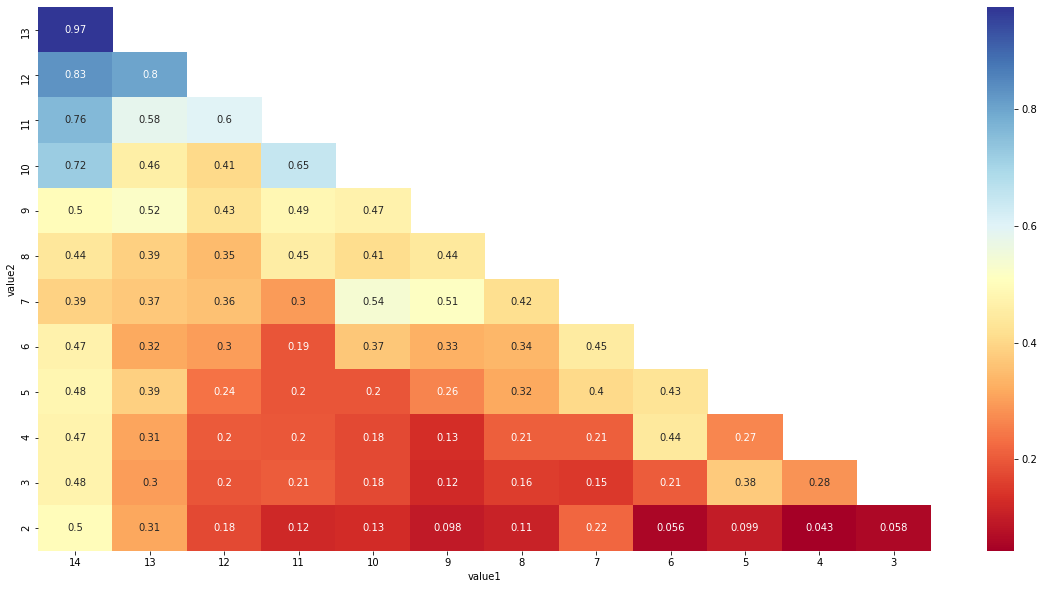

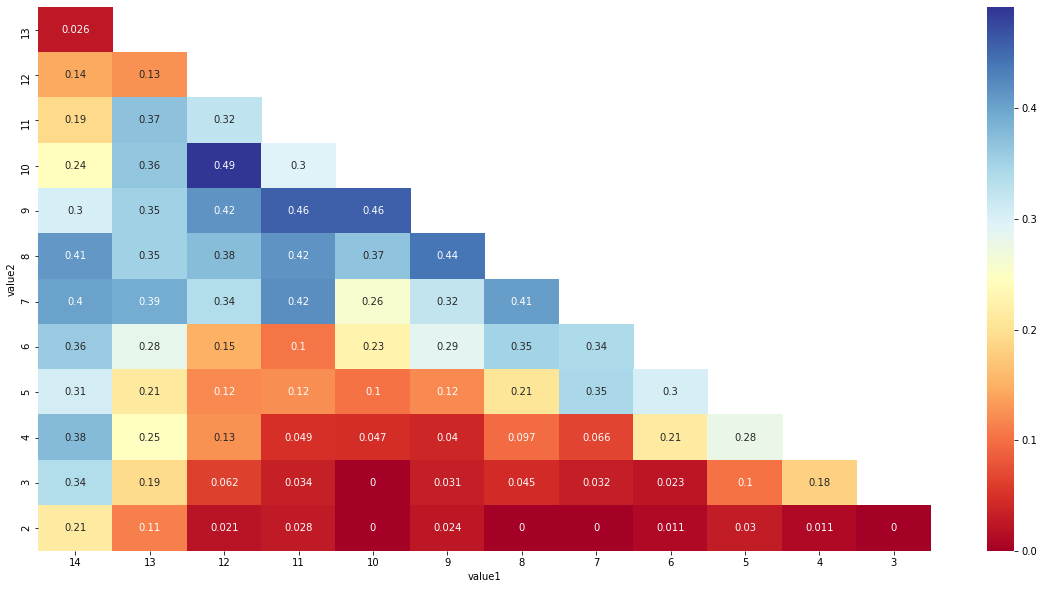

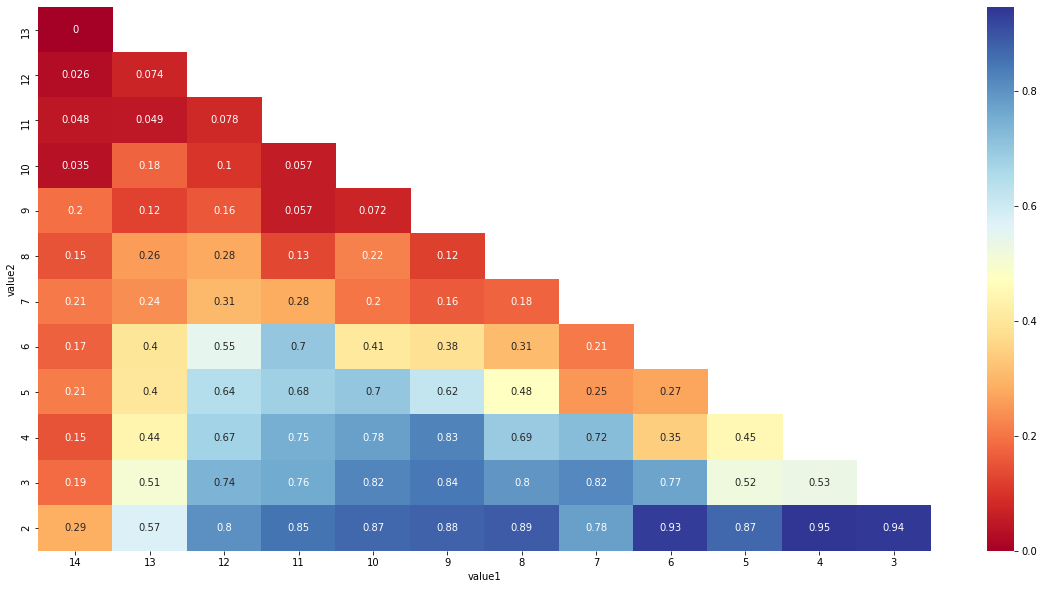

In [11]:
import seaborn as sns
htype = "o"
offsuit = shands.query(f"{htype}").groupby(["value1", "value2"])[["raises", "calls", "folds"]].mean().reset_index()
offsuit_sum = shands.query(f"{htype}").groupby(["value1", "value2"])[["raises", "calls", "folds"]].sum().reset_index()
offsuit = pd.pivot_table(offsuit, index="value1", columns="value2").sort_index(ascending=False)
offsuit_sum = pd.pivot_table(offsuit_sum, index="value1", columns="value2").sort_index(ascending=False)
plt.figure(figsize=(20, 10))
cols = sorted(offsuit.raises.columns.tolist(), reverse=True)
sns.heatmap(offsuit.raises[cols].T, cmap="RdYlBu", annot=True)
plt.show()
plt.figure(figsize=(20, 10))
sns.heatmap(offsuit.calls[cols].T, cmap="RdYlBu", annot=True)
plt.show()
plt.figure(figsize=(20, 10))
sns.heatmap(offsuit.folds[cols].T, cmap="RdYlBu", annot=True)
plt.show()

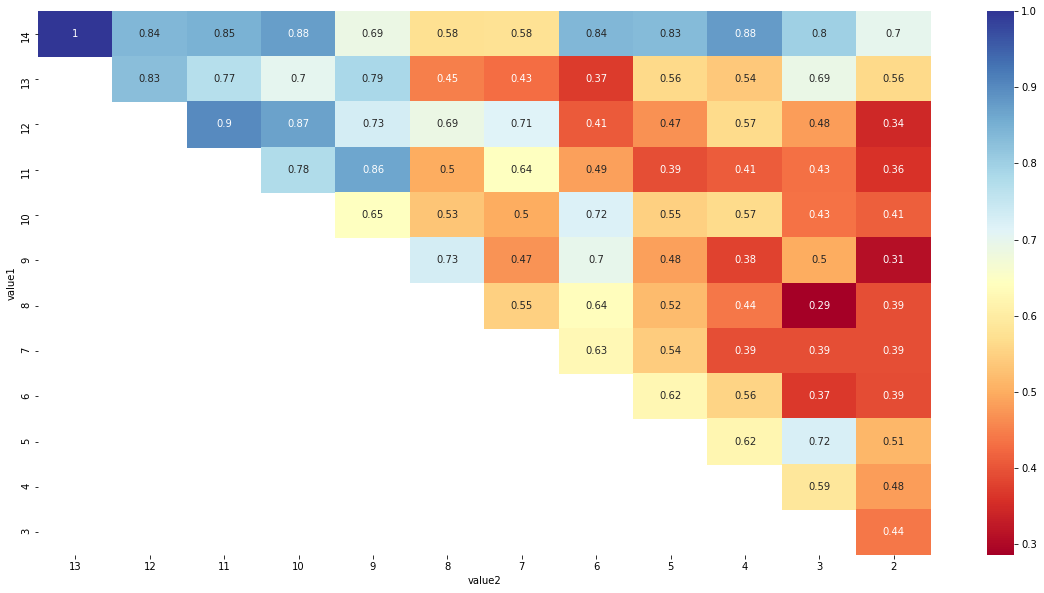

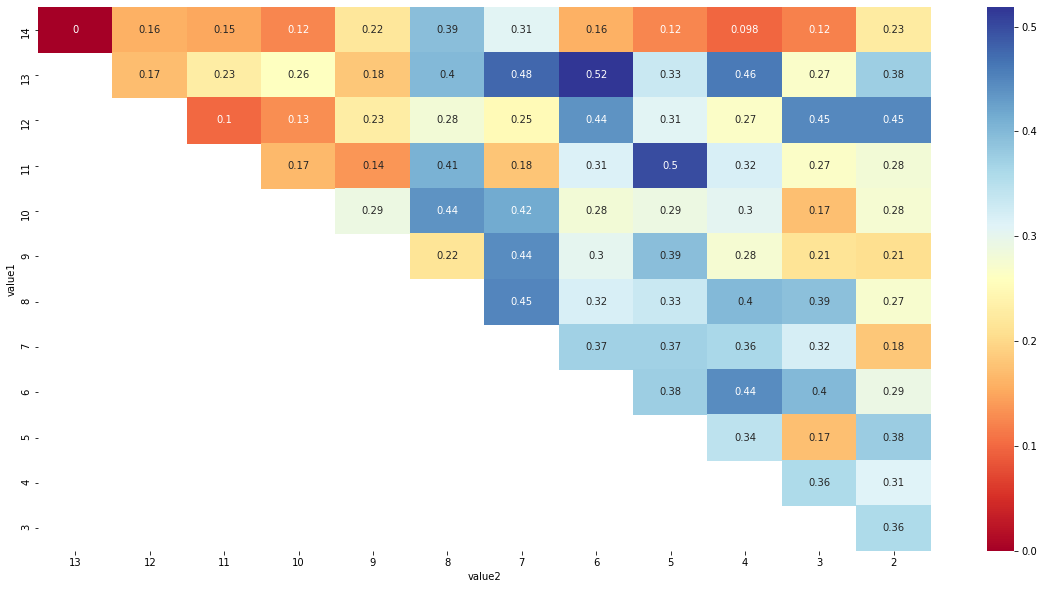

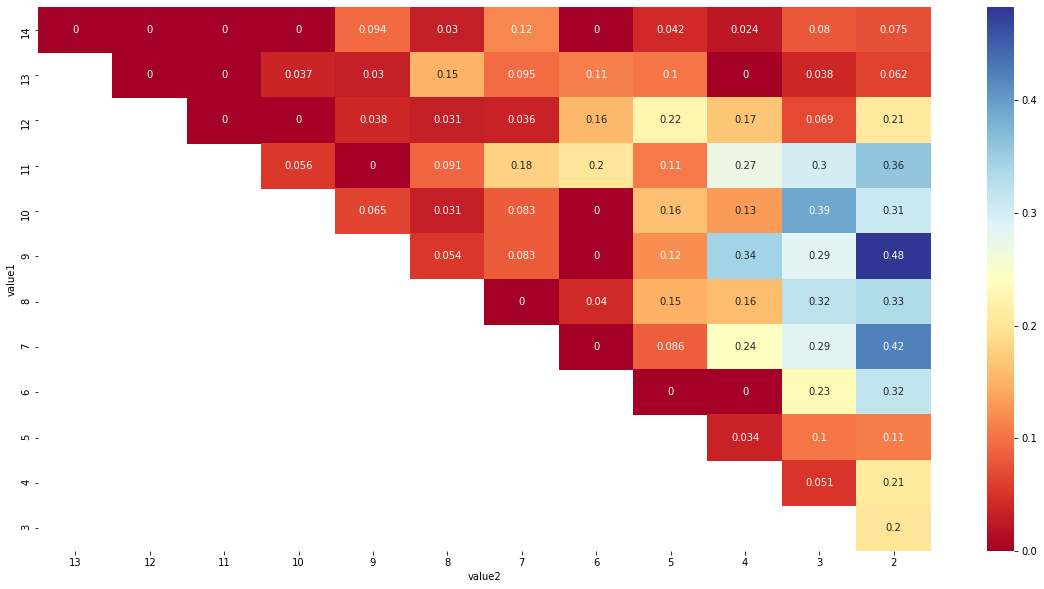

In [12]:
htype = "s"
suited = shands.query(f"{htype}").groupby(["value1", "value2"])[["raises", "calls", "folds"]].mean().reset_index()
suited_sum = shands.query(f"{htype}").groupby(["value1", "value2"])[["raises", "calls", "folds"]].sum().reset_index()
suited = pd.pivot_table(suited, index="value1", columns="value2").sort_index(ascending=False)
suited_sum = pd.pivot_table(suited_sum, index="value1", columns="value2").sort_index(ascending=False)
plt.figure(figsize=(20, 10))
cols = sorted(suited.raises.columns.tolist(), reverse=True)
sns.heatmap(suited.raises[cols], cmap="RdYlBu", annot=True)
plt.show()
plt.figure(figsize=(20, 10))
sns.heatmap(suited.calls[cols], cmap="RdYlBu", annot=True)
plt.show()
plt.figure(figsize=(20, 10))
sns.heatmap(suited.folds[cols], cmap="RdYlBu", annot=True)
plt.show()

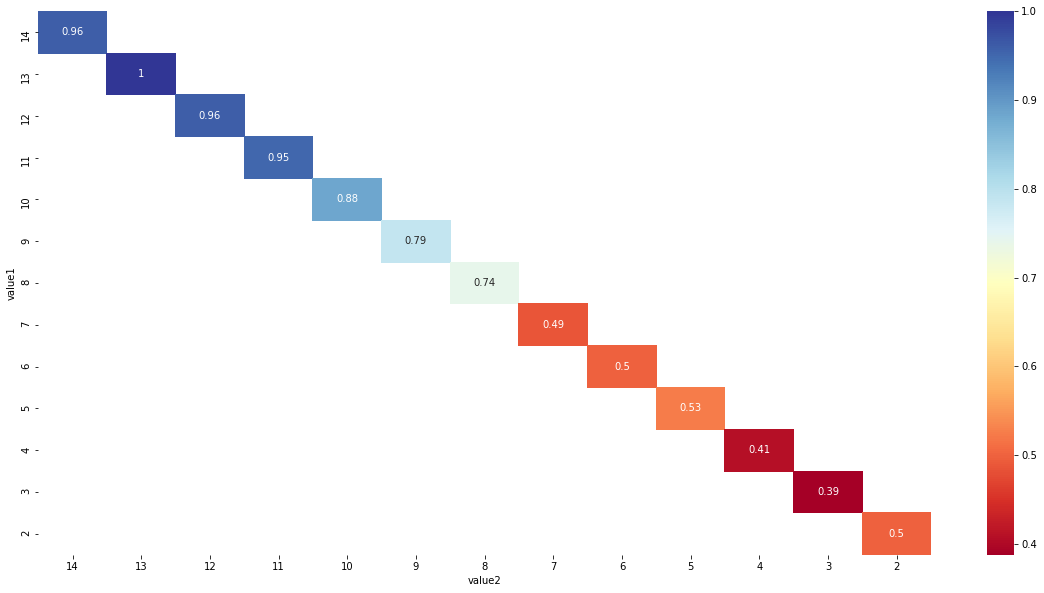

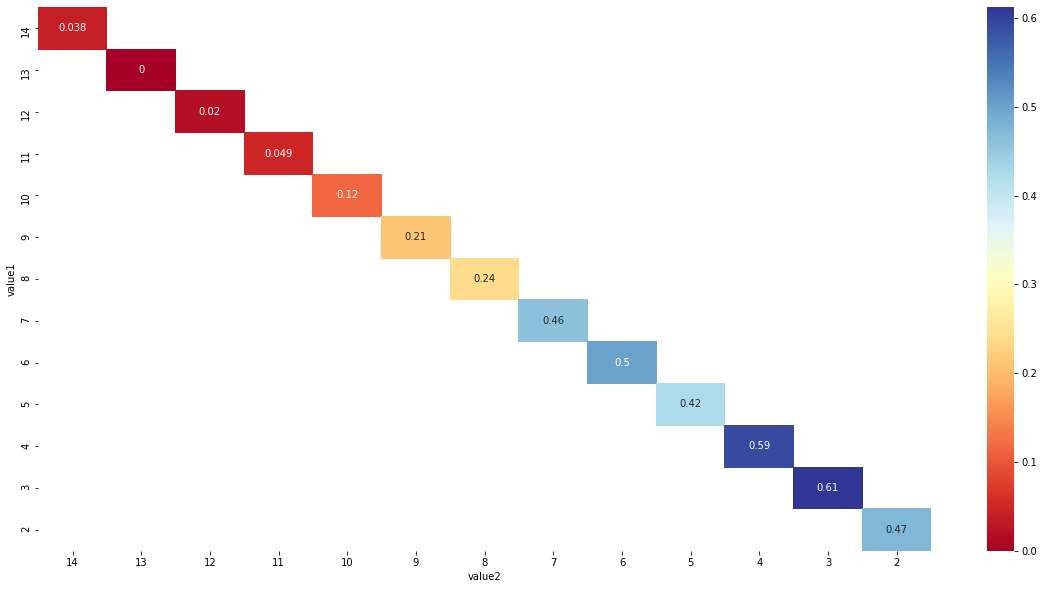

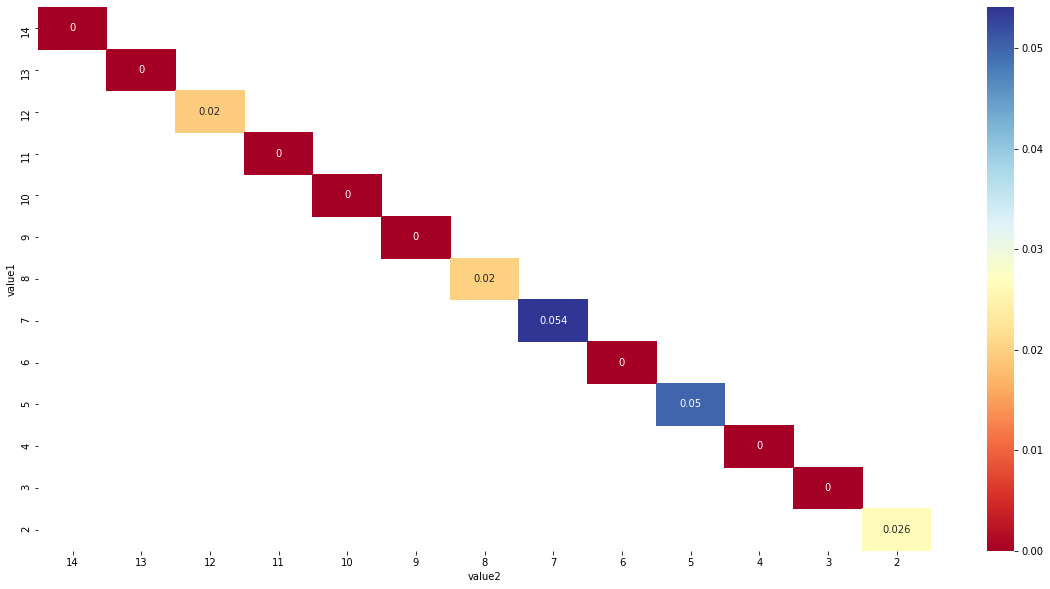

In [13]:
htype = "p"
paired = shands.query(f"{htype}").groupby(["value1", "value2"])[["raises", "calls", "folds"]].mean().reset_index()
paired_sum = shands.query(f"{htype}").groupby(["value1", "value2"])[["raises", "calls", "folds"]].sum().reset_index()
paired = pd.pivot_table(paired, index="value1", columns="value2").sort_index(ascending=False)
paired_sum = pd.pivot_table(paired_sum, index="value1", columns="value2").sort_index(ascending=False)
plt.figure(figsize=(20, 10))
cols = sorted(paired.raises.columns.tolist(), reverse=True)
sns.heatmap(paired.raises[cols], cmap="RdYlBu", annot=True)
plt.show()
plt.figure(figsize=(20, 10))
sns.heatmap(paired.calls[cols], cmap="RdYlBu", annot=True)
plt.show()
plt.figure(figsize=(20, 10))
sns.heatmap(paired.folds[cols], cmap="RdYlBu", annot=True)
plt.show()

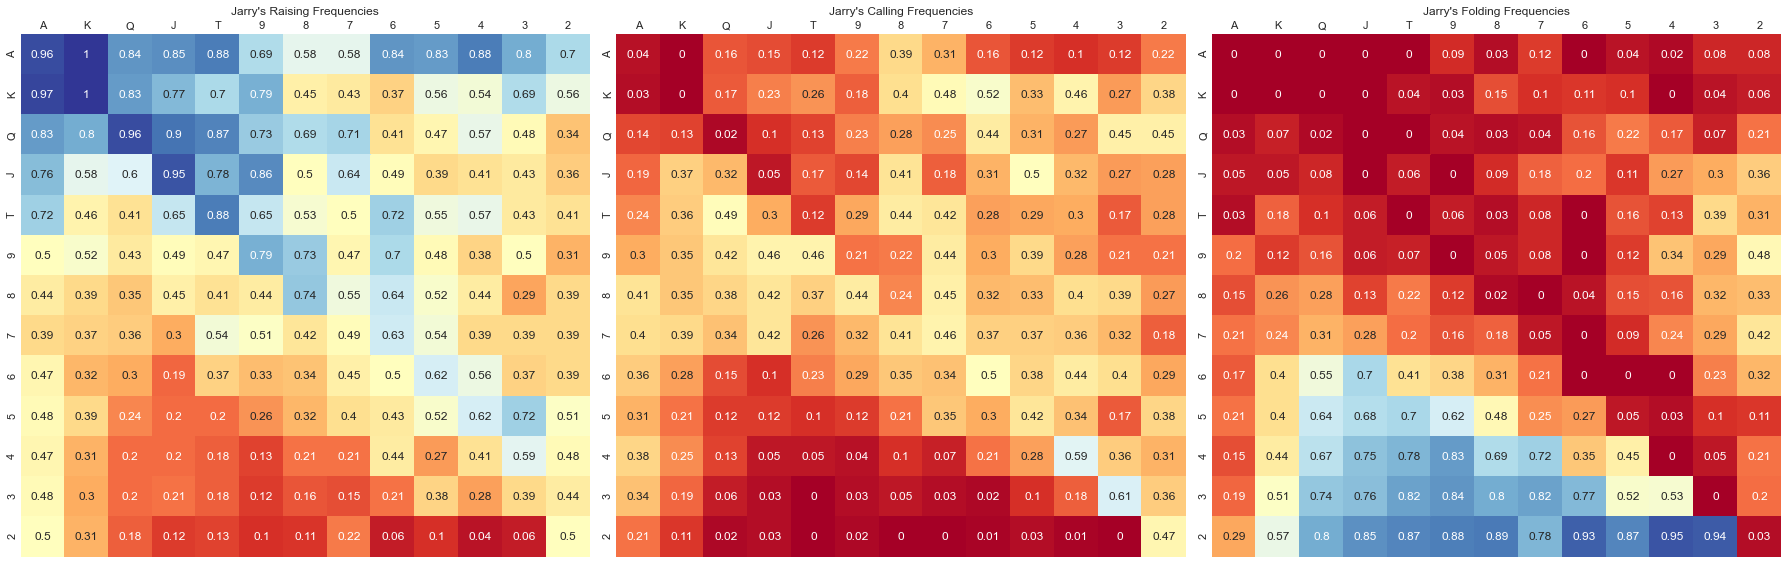

In [14]:
cols = list(reversed(list(range(2, 15))))

oraise = offsuit.raises.T
for i in range(2, 15):
    if i in oraise.index:
        continue
    oraise = oraise.append(pd.Series([0] * oraise.shape[1], index=oraise.columns, name=i))
oraise = oraise.sort_index(ascending=False).fillna(0)
for i in range(2, 15):
    if i in oraise.columns:
        continue
    oraise[i] = 0
oraise = oraise[cols]
    
sraise = suited.raises
for i in range(2, 15):
    if i in sraise.index:
        continue
    sraise = sraise.append(pd.Series([0] * sraise.shape[1], index=sraise.columns, name=i))
sraise = sraise.sort_index(ascending=False).fillna(0)
for i in range(2, 15):
    if i in sraise.columns:
        continue
    sraise[i] = 0
sraise = sraise[cols]


praise = paired.raises
for i in range(2, 15):
    if i in praise.index:
        continue
    praise = praise.append(pd.Series([0] * praise.shape[1], index=praise.columns, name=i))
praise = praise.sort_index(ascending=False).fillna(0)
for i in range(2, 15):
    if i in praise.columns:
        continue
    praise[i] = 0
praise = praise[cols]



new_cols = sorted(praise.columns.tolist(), reverse=True)
new_cols[0] = "A"
new_cols[1] = "K"
new_cols[2] = "Q"
new_cols[3] = "J"
new_cols[4] = "T"

raises = oraise + sraise + praise 
raises.columns = new_cols
raises.index = new_cols


ocalls = offsuit.calls.T
for i in range(2, 15):
    if i in ocalls.index:
        continue
    ocalls = ocalls.append(pd.Series([0] * ocalls.shape[1], index=ocalls.columns, name=i))
ocalls = ocalls.sort_index(ascending=False).fillna(0)
for i in range(2, 15):
    if i in ocalls.columns:
        continue
    ocalls[i] = 0
ocalls = ocalls[cols]
    
scalls = suited.calls
for i in range(2, 15):
    if i in scalls.index:
        continue
    scalls = scalls.append(pd.Series([0] * scalls.shape[1], index=scalls.columns, name=i))
scalls = scalls.sort_index(ascending=False).fillna(0)
for i in range(2, 15):
    if i in scalls.columns:
        continue
    scalls[i] = 0
scalls = scalls[cols]


pcalls = paired.calls
for i in range(2, 15):
    if i in pcalls.index:
        continue
    pcalls = pcalls.append(pd.Series([0] * pcalls.shape[1], index=pcalls.columns, name=i))
pcalls = pcalls.sort_index(ascending=False).fillna(0)
for i in range(2, 15):
    if i in pcalls.columns:
        continue
    pcalls[i] = 0
pcalls = pcalls[cols]


calls = ocalls + scalls + pcalls 
calls.columns = new_cols
calls.index = new_cols



ofolds = offsuit.folds.T
for i in range(2, 15):
    if i in ofolds.index:
        continue
    ofolds = ofolds.append(pd.Series([0] * ofolds.shape[1], index=ofolds.columns, name=i))
ofolds = ofolds.sort_index(ascending=False).fillna(0)
for i in range(2, 15):
    if i in ofolds.columns:
        continue
    ofolds[i] = 0
ofolds = ofolds[cols]
    
sfolds = suited.folds
for i in range(2, 15):
    if i in sfolds.index:
        continue
    sfolds = sfolds.append(pd.Series([0] * sfolds.shape[1], index=sfolds.columns, name=i))
sfolds = sfolds.sort_index(ascending=False).fillna(0)
for i in range(2, 15):
    if i in sfolds.columns:
        continue
    sfolds[i] = 0
sfolds = sfolds[cols]


pfolds = paired.folds
for i in range(2, 15):
    if i in pfolds.index:
        continue
    pfolds = pfolds.append(pd.Series([0] * pfolds.shape[1], index=pfolds.columns, name=i))
pfolds = pfolds.sort_index(ascending=False).fillna(0)
for i in range(2, 15):
    if i in pfolds.columns:
        continue
    pfolds[i] = 0
pfolds = pfolds[cols]

folds = ofolds + sfolds + pfolds 
folds.columns = new_cols
folds.index = new_cols

sns.set()
fig, ax = plt.subplots(1, 3, figsize=(25, 8))
ax = ax.flatten()

PL = pl.capitalize()

a = ax[0]
sns.heatmap(raises.round(2), cmap="RdYlBu", annot=True, cbar=False, ax=a, center=0.5)
a.set_title(f"{PL}'s Raising Frequencies")
a.xaxis.tick_top()
a.tick_params(length=0)

a = ax[1]
sns.heatmap(calls.round(2), cmap="RdYlBu", annot=True, cbar=False, ax=a, center=0.5)
a.set_title(f"{PL}'s Calling Frequencies")
a.xaxis.tick_top()
a.tick_params(length=0)

a = ax[2]
sns.heatmap(folds.round(2), cmap="RdYlBu", annot=True, cbar=False, ax=a, center=0.5, vmin=0, vmax=1)
a.set_title(f"{PL}'s Folding Frequencies")
a.xaxis.tick_top()
a.tick_params(length=0)
plt.tight_layout()
plt.show()

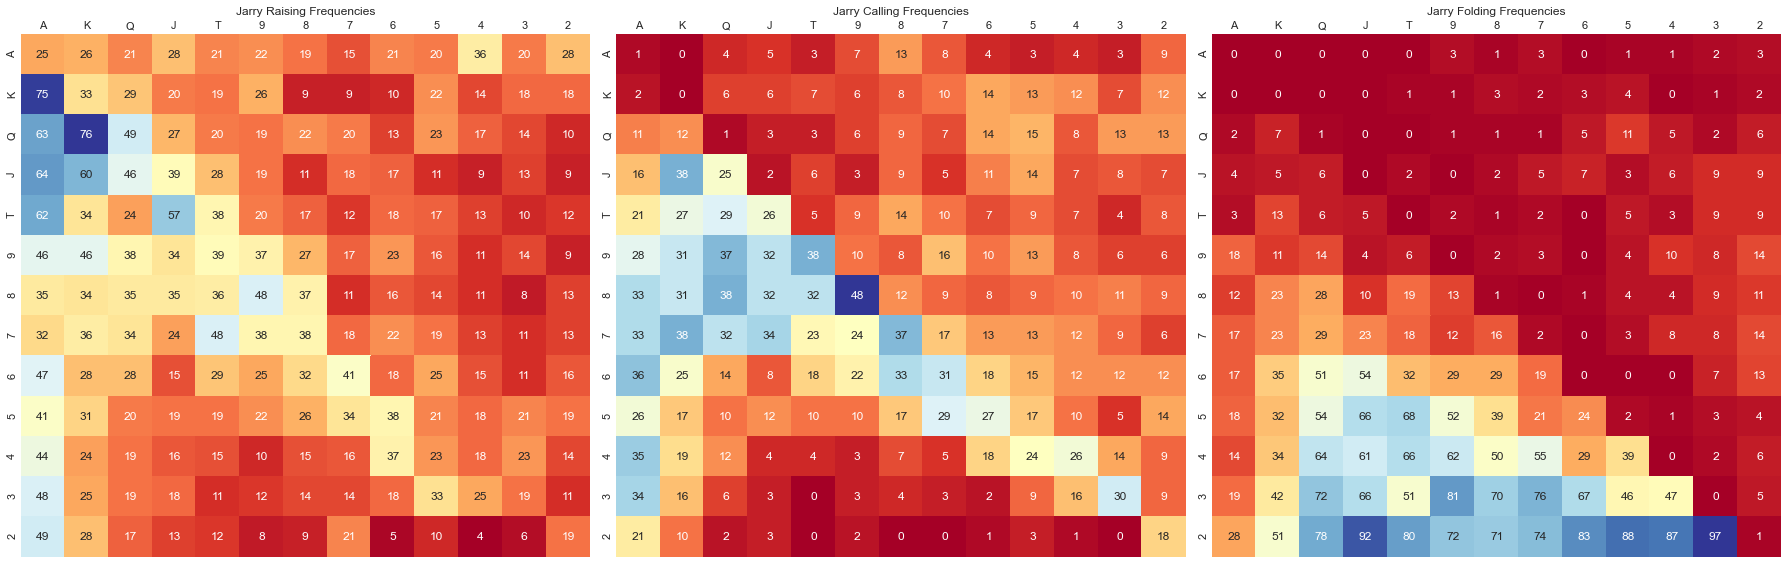

In [15]:
cols = list(reversed(list(range(2, 15))))

oraise = offsuit_sum.raises.T
for i in range(2, 15):
    if i in oraise.index:
        continue
    oraise = oraise.append(pd.Series([0] * oraise.shape[1], index=oraise.columns, name=i))
oraise = oraise.sort_index(ascending=False).fillna(0)
for i in range(2, 15):
    if i in oraise.columns:
        continue
    oraise[i] = 0
oraise = oraise[cols]
    
sraise = suited_sum.raises
for i in range(2, 15):
    if i in sraise.index:
        continue
    sraise = sraise.append(pd.Series([0] * sraise.shape[1], index=sraise.columns, name=i))
sraise = sraise.sort_index(ascending=False).fillna(0)
for i in range(2, 15):
    if i in sraise.columns:
        continue
    sraise[i] = 0
sraise = sraise[cols]


praise = paired_sum.raises
for i in range(2, 15):
    if i in praise.index:
        continue
    praise = praise.append(pd.Series([0] * praise.shape[1], index=praise.columns, name=i))
praise = praise.sort_index(ascending=False).fillna(0)
for i in range(2, 15):
    if i in praise.columns:
        continue
    praise[i] = 0
praise = praise[cols]



new_cols = sorted(praise.columns.tolist(), reverse=True)
new_cols[0] = "A"
new_cols[1] = "K"
new_cols[2] = "Q"
new_cols[3] = "J"
new_cols[4] = "T"

raises = oraise + sraise + praise 
raises.columns = new_cols
raises.index = new_cols


ocalls = offsuit_sum.calls.T
for i in range(2, 15):
    if i in ocalls.index:
        continue
    ocalls = ocalls.append(pd.Series([0] * ocalls.shape[1], index=ocalls.columns, name=i))
ocalls = ocalls.sort_index(ascending=False).fillna(0)
for i in range(2, 15):
    if i in ocalls.columns:
        continue
    ocalls[i] = 0
ocalls = ocalls[cols]
    
scalls = suited_sum.calls
for i in range(2, 15):
    if i in scalls.index:
        continue
    scalls = scalls.append(pd.Series([0] * scalls.shape[1], index=scalls.columns, name=i))
scalls = scalls.sort_index(ascending=False).fillna(0)
for i in range(2, 15):
    if i in scalls.columns:
        continue
    scalls[i] = 0
scalls = scalls[cols]


pcalls = paired_sum.calls
for i in range(2, 15):
    if i in pcalls.index:
        continue
    pcalls = pcalls.append(pd.Series([0] * pcalls.shape[1], index=pcalls.columns, name=i))
pcalls = pcalls.sort_index(ascending=False).fillna(0)
for i in range(2, 15):
    if i in pcalls.columns:
        continue
    pcalls[i] = 0
pcalls = pcalls[cols]


calls = ocalls + scalls + pcalls 
calls.columns = new_cols
calls.index = new_cols



ofolds = offsuit_sum.folds.T
for i in range(2, 15):
    if i in ofolds.index:
        continue
    ofolds = ofolds.append(pd.Series([0] * ofolds.shape[1], index=ofolds.columns, name=i))
ofolds = ofolds.sort_index(ascending=False).fillna(0)
for i in range(2, 15):
    if i in ofolds.columns:
        continue
    ofolds[i] = 0
ofolds = ofolds[cols]
    
sfolds = suited_sum.folds
for i in range(2, 15):
    if i in sfolds.index:
        continue
    sfolds = sfolds.append(pd.Series([0] * sfolds.shape[1], index=sfolds.columns, name=i))
sfolds = sfolds.sort_index(ascending=False).fillna(0)
for i in range(2, 15):
    if i in sfolds.columns:
        continue
    sfolds[i] = 0
sfolds = sfolds[cols]


pfolds = paired_sum.folds
for i in range(2, 15):
    if i in pfolds.index:
        continue
    pfolds = pfolds.append(pd.Series([0] * pfolds.shape[1], index=pfolds.columns, name=i))
pfolds = pfolds.sort_index(ascending=False).fillna(0)
for i in range(2, 15):
    if i in pfolds.columns:
        continue
    pfolds[i] = 0
pfolds = pfolds[cols]

folds = ofolds + sfolds + pfolds 
folds.columns = new_cols
folds.index = new_cols

sns.set()
fig, ax = plt.subplots(1, 3, figsize=(25, 8))
ax = ax.flatten()

PL = pl.capitalize()

a = ax[0]
sns.heatmap(raises.round(2), cmap="RdYlBu", annot=True, cbar=False, ax=a)
a.set_title(f"{PL} Raising Frequencies")
a.xaxis.tick_top()
a.tick_params(length=0)

a = ax[1]
sns.heatmap(calls.round(2), cmap="RdYlBu", annot=True, cbar=False, ax=a)
a.set_title(f"{PL} Calling Frequencies")
a.xaxis.tick_top()
a.tick_params(length=0)

a = ax[2]
sns.heatmap(folds.round(2), cmap="RdYlBu", annot=True, cbar=False, ax=a)
a.set_title(f"{PL} Folding Frequencies")
a.xaxis.tick_top()
a.tick_params(length=0)
plt.tight_layout()
plt.show()

9640.0


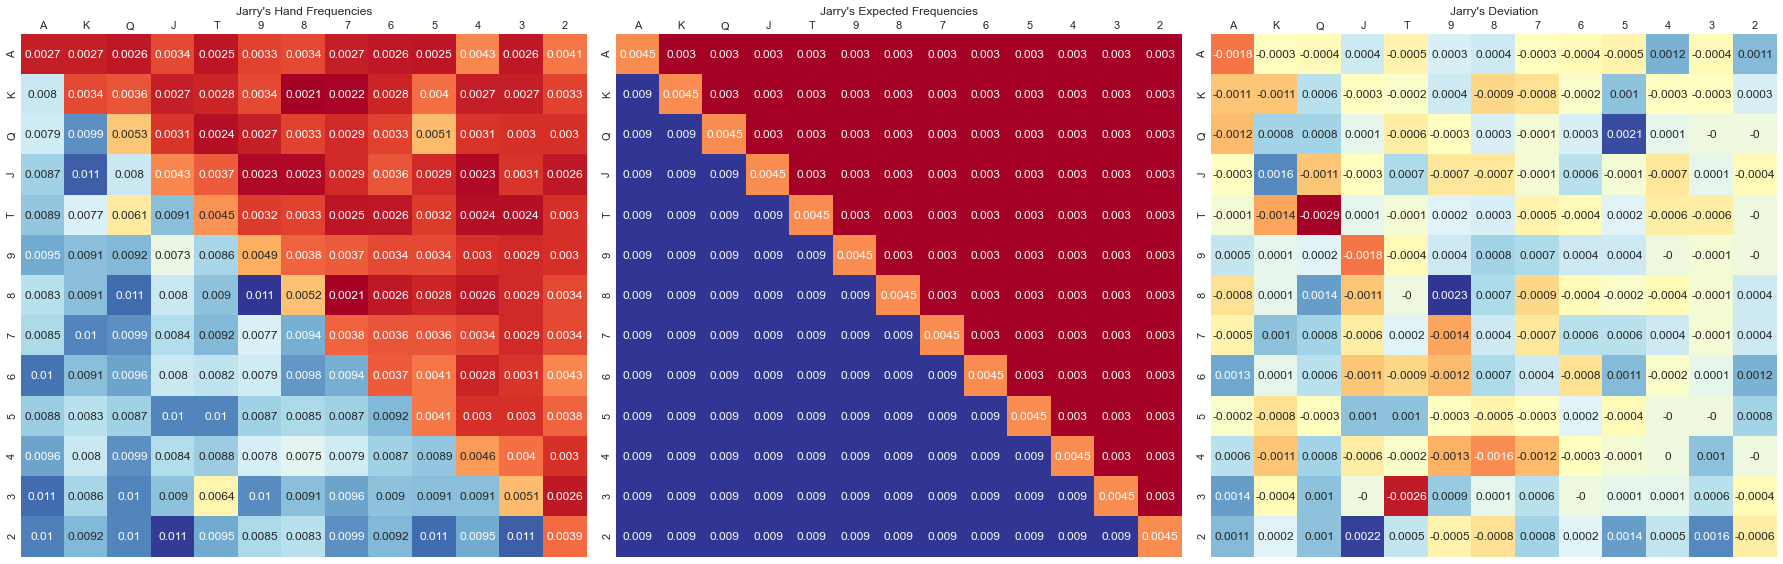

In [17]:
sns.set()
fig, ax = plt.subplots(1, 3, figsize=(25, 8))
ax = ax.flatten()
a = ax[0]
total = (raises+calls+folds).sum().sum()
print(total)
sns.heatmap(((raises+calls+folds)/ total).round(4), cmap="RdYlBu", annot=True, cbar=False, ax=a)
a.set_title(f"{PL}'s Hand Frequencies")
a.xaxis.tick_top()
a.tick_params(length=0)

a = ax[1]
data = np.eye(13) * (6 / 1326)
data += (np.tril(np.zeros((13, 13)) + 1) - np.eye(13)) * (12 / 1326)
data += (np.triu(np.zeros((13, 13)) + 1) - np.eye(13)) * (4 / 1326)
expected = pd.DataFrame(data, index=new_cols, columns=new_cols)
sns.heatmap(expected.round(4), cmap="RdYlBu", annot=True, cbar=False, ax=a)
a.set_title(f"{PL}'s Expected Frequencies")
a.xaxis.tick_top()
a.tick_params(length=0)

a = ax[2]
sns.heatmap((((raises+calls+folds)/ total) - expected).round(4), cmap="RdYlBu", annot=True, cbar=False, ax=a)
a.set_title(f"{PL}'s Deviation")
a.xaxis.tick_top()
a.tick_params(length=0)
plt.tight_layout()
plt.show()